In [ ]:

# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.seasonal import STL
from datetime import datetime as dt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
# Load data and display first few columns
data = pd.read_csv("transaction_data.csv")
display(data.head())

date      amount  client_id
0  2017-05-24   63.058251     975386
1  2021-08-29  118.253665     955735
2  2020-08-23  102.693555     975386
3  2019-04-27   78.942714     160736
4  2017-10-20   56.949652     143171

In [ ]:
# Check data types of columns and total number of values
data.info()
# Change date column to date format
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
# Get rid of days
data['date'] = data['date'].dt.strftime('%Y-%m')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22239 entries, 0 to 22238
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       22239 non-null  object 
 1   amount     22239 non-null  float64
 2   client_id  22239 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 521.4+ KB


In [ ]:
# Check for NAN and print number of unique values in each column
print("NAN? ", data.isnull().values.any())
print("Unique values: \n\n", data.nunique())

NAN?  False
Unique values: 

 date            60
amount       22239
client_id       14
dtype: int64


In [ ]:

# Identify our clients
clients = data.client_id.unique()
n_clients = len(clients)
print(f"Our clients are: \n {clients}")
print(f"There are a total of {n_clients} unique clients.")

Our clients are: 
 [975386 955735 160736 143171 986180 427729 170552 457867 588453 955698
 966823 169440 589131 499072]
There are a total of 14 unique clients.


In [ ]:
df_all = data.groupby(by=[data.date], as_index = False).agg(amount_mean = ('amount', 'mean'), amount_count = ('client_id', 'count'))
# display(df_all.head())

df = data.groupby(by=['client_id', data.date], as_index = False).agg(amount_mean = ('amount', 'mean'), amount_count = ('amount', 'count'))
# display(df.head())

# Transform to date format again
df['date'] = pd.to_datetime(df['date'], format='%Y-%m')
df_all['date'] = pd.to_datetime(df_all['date'], format='%Y-%m')
# Get rid of days
# df['date'] = df['date'].dt.strftime('%Y-%m')
display(df.head())

client_id       date  amount_mean  amount_count
0     143171 2017-01-01    50.059780             6
1     143171 2017-02-01    67.008089            27
2     143171 2017-03-01    64.003178            27
3     143171 2017-04-01    62.990814            27
4     143171 2017-05-01    62.980939            28

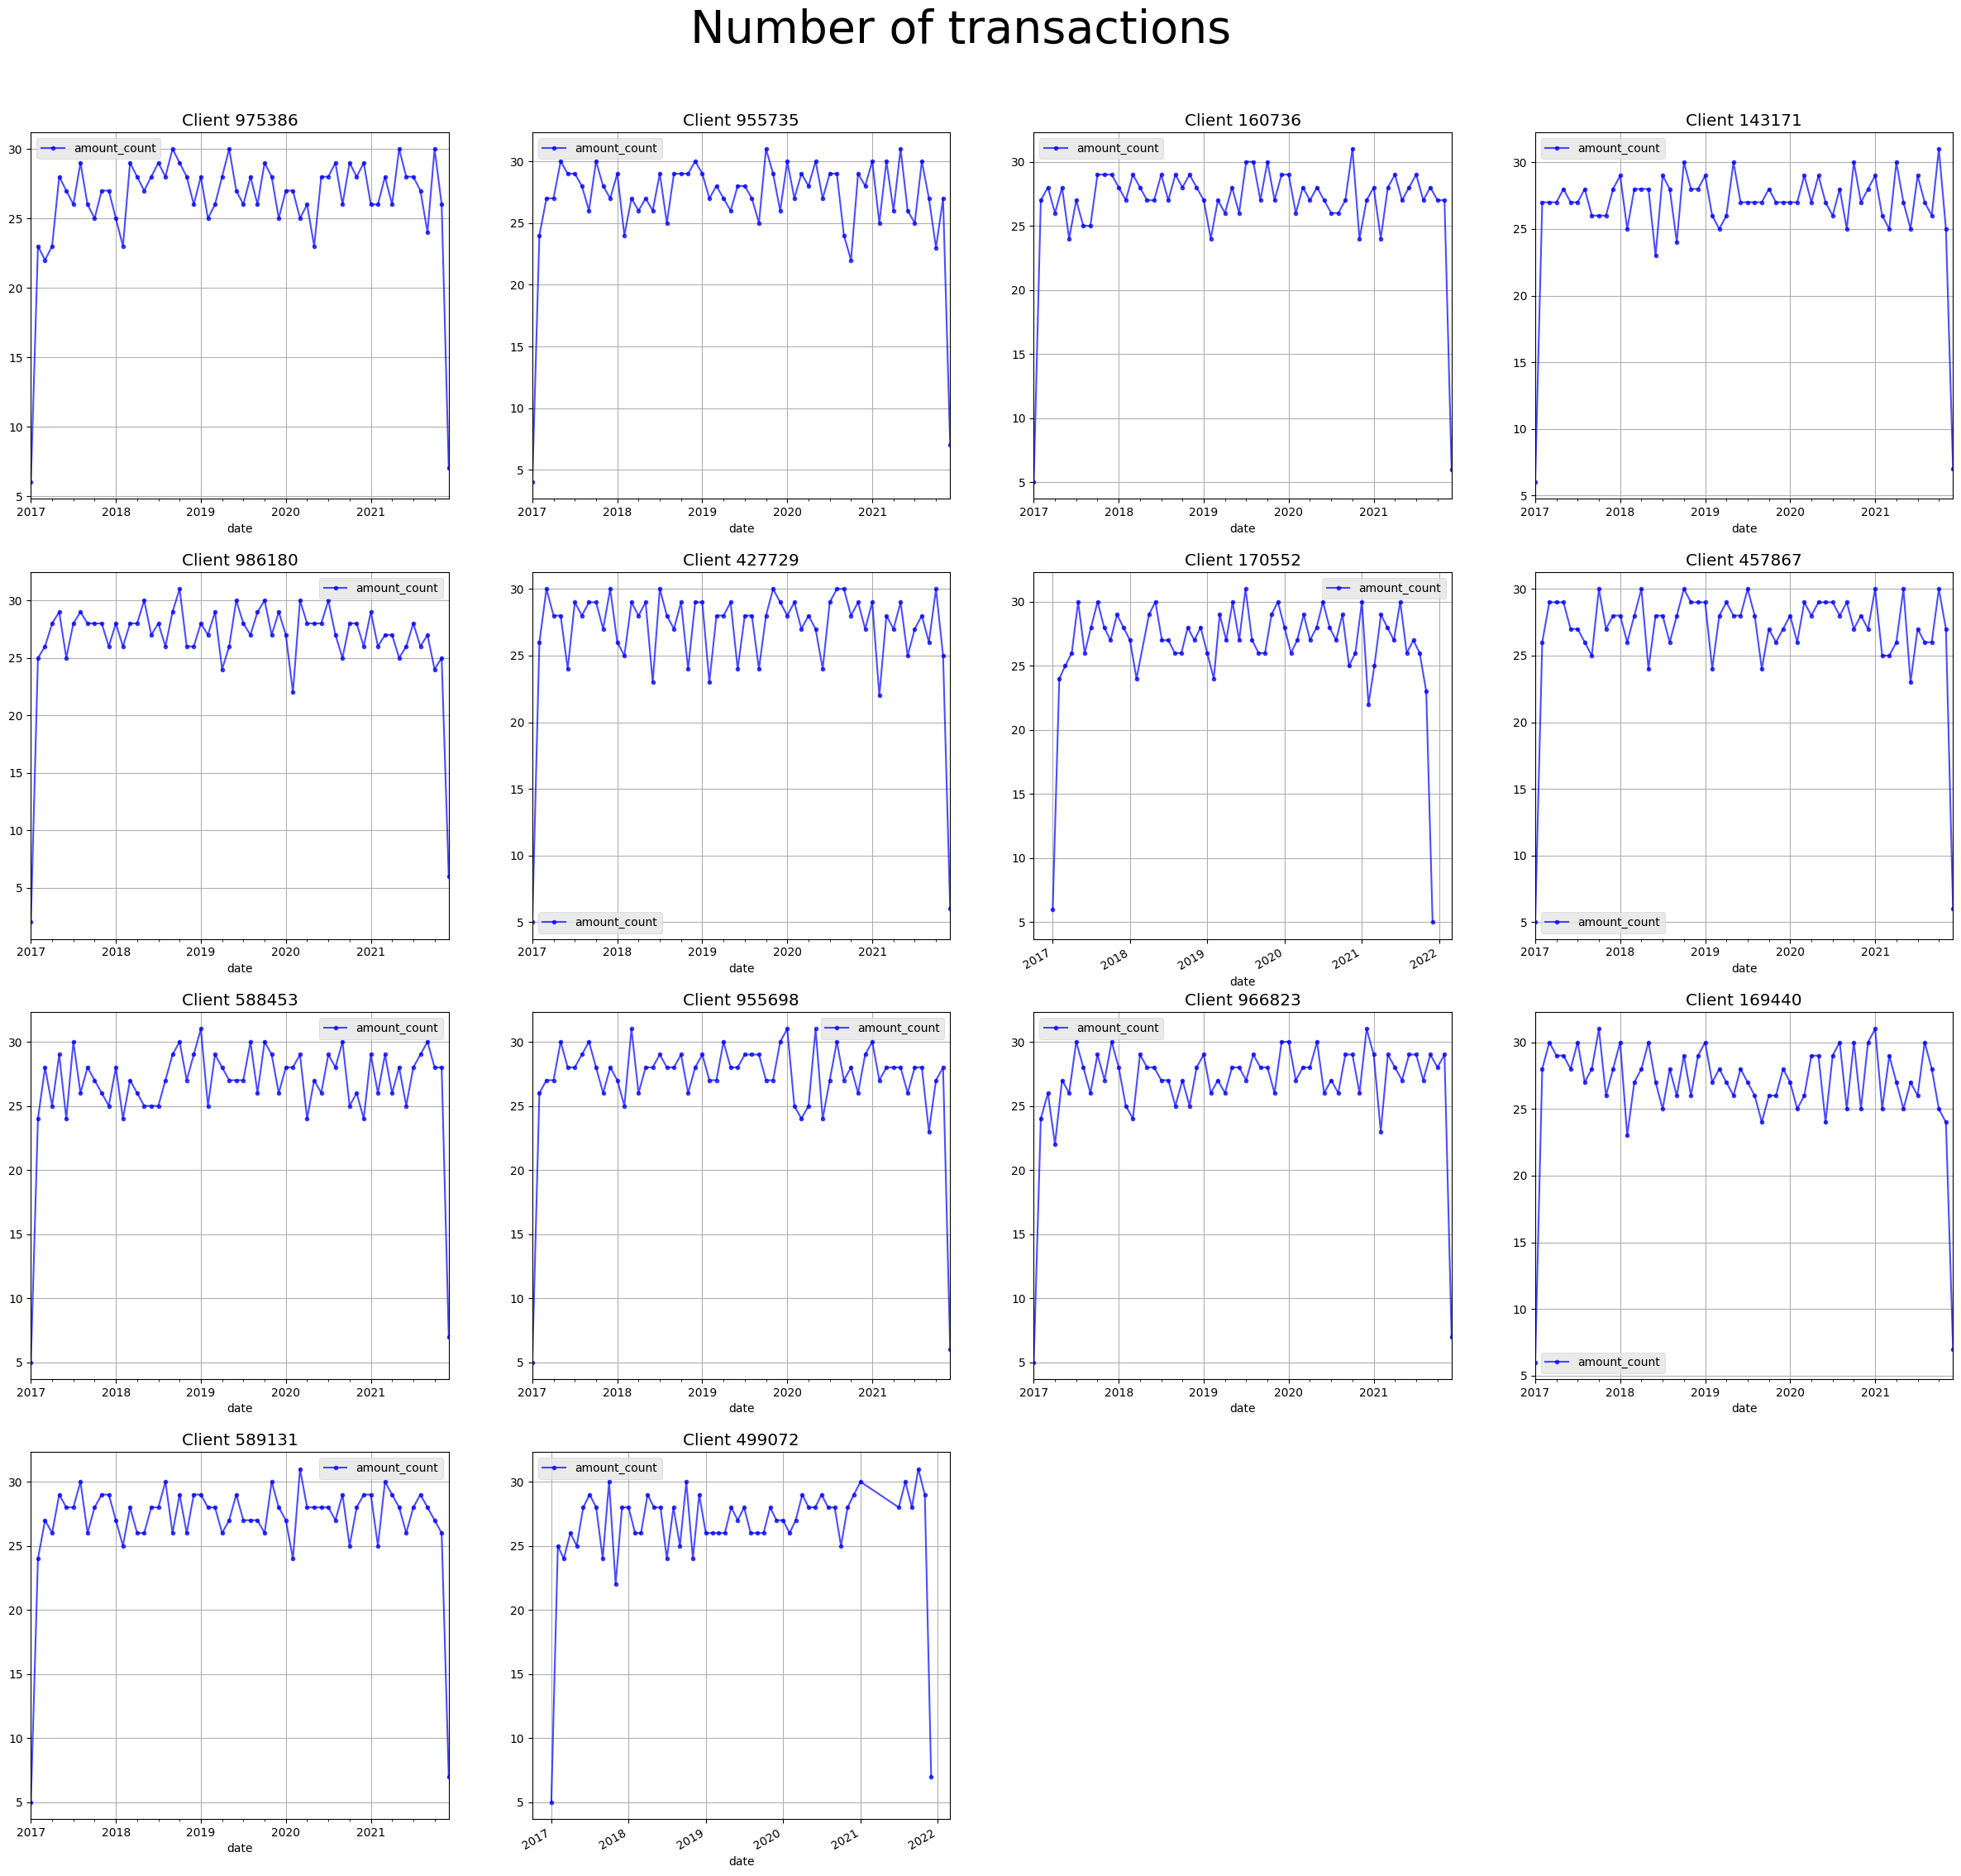

In [ ]:
fig, axes = plt.subplots(nrows= 4, ncols=4, figsize = (30,30))
plt.style.use('ggplot')

for i, ax in enumerate(axes.flat):
    if i == n_clients:
        break
    df[df['client_id'] == clients[i]].plot(x= 'date', y= 'amount_count', ax=ax, marker='.', color = 'b', alpha = 0.7)
    ax.set_title('Client {}'.format(clients[i]))

fig.delaxes(axes[3][3])
fig.delaxes(axes[3][2])
fig.suptitle('Number of transactions', fontsize=40, y = 0.93)
plt.show()

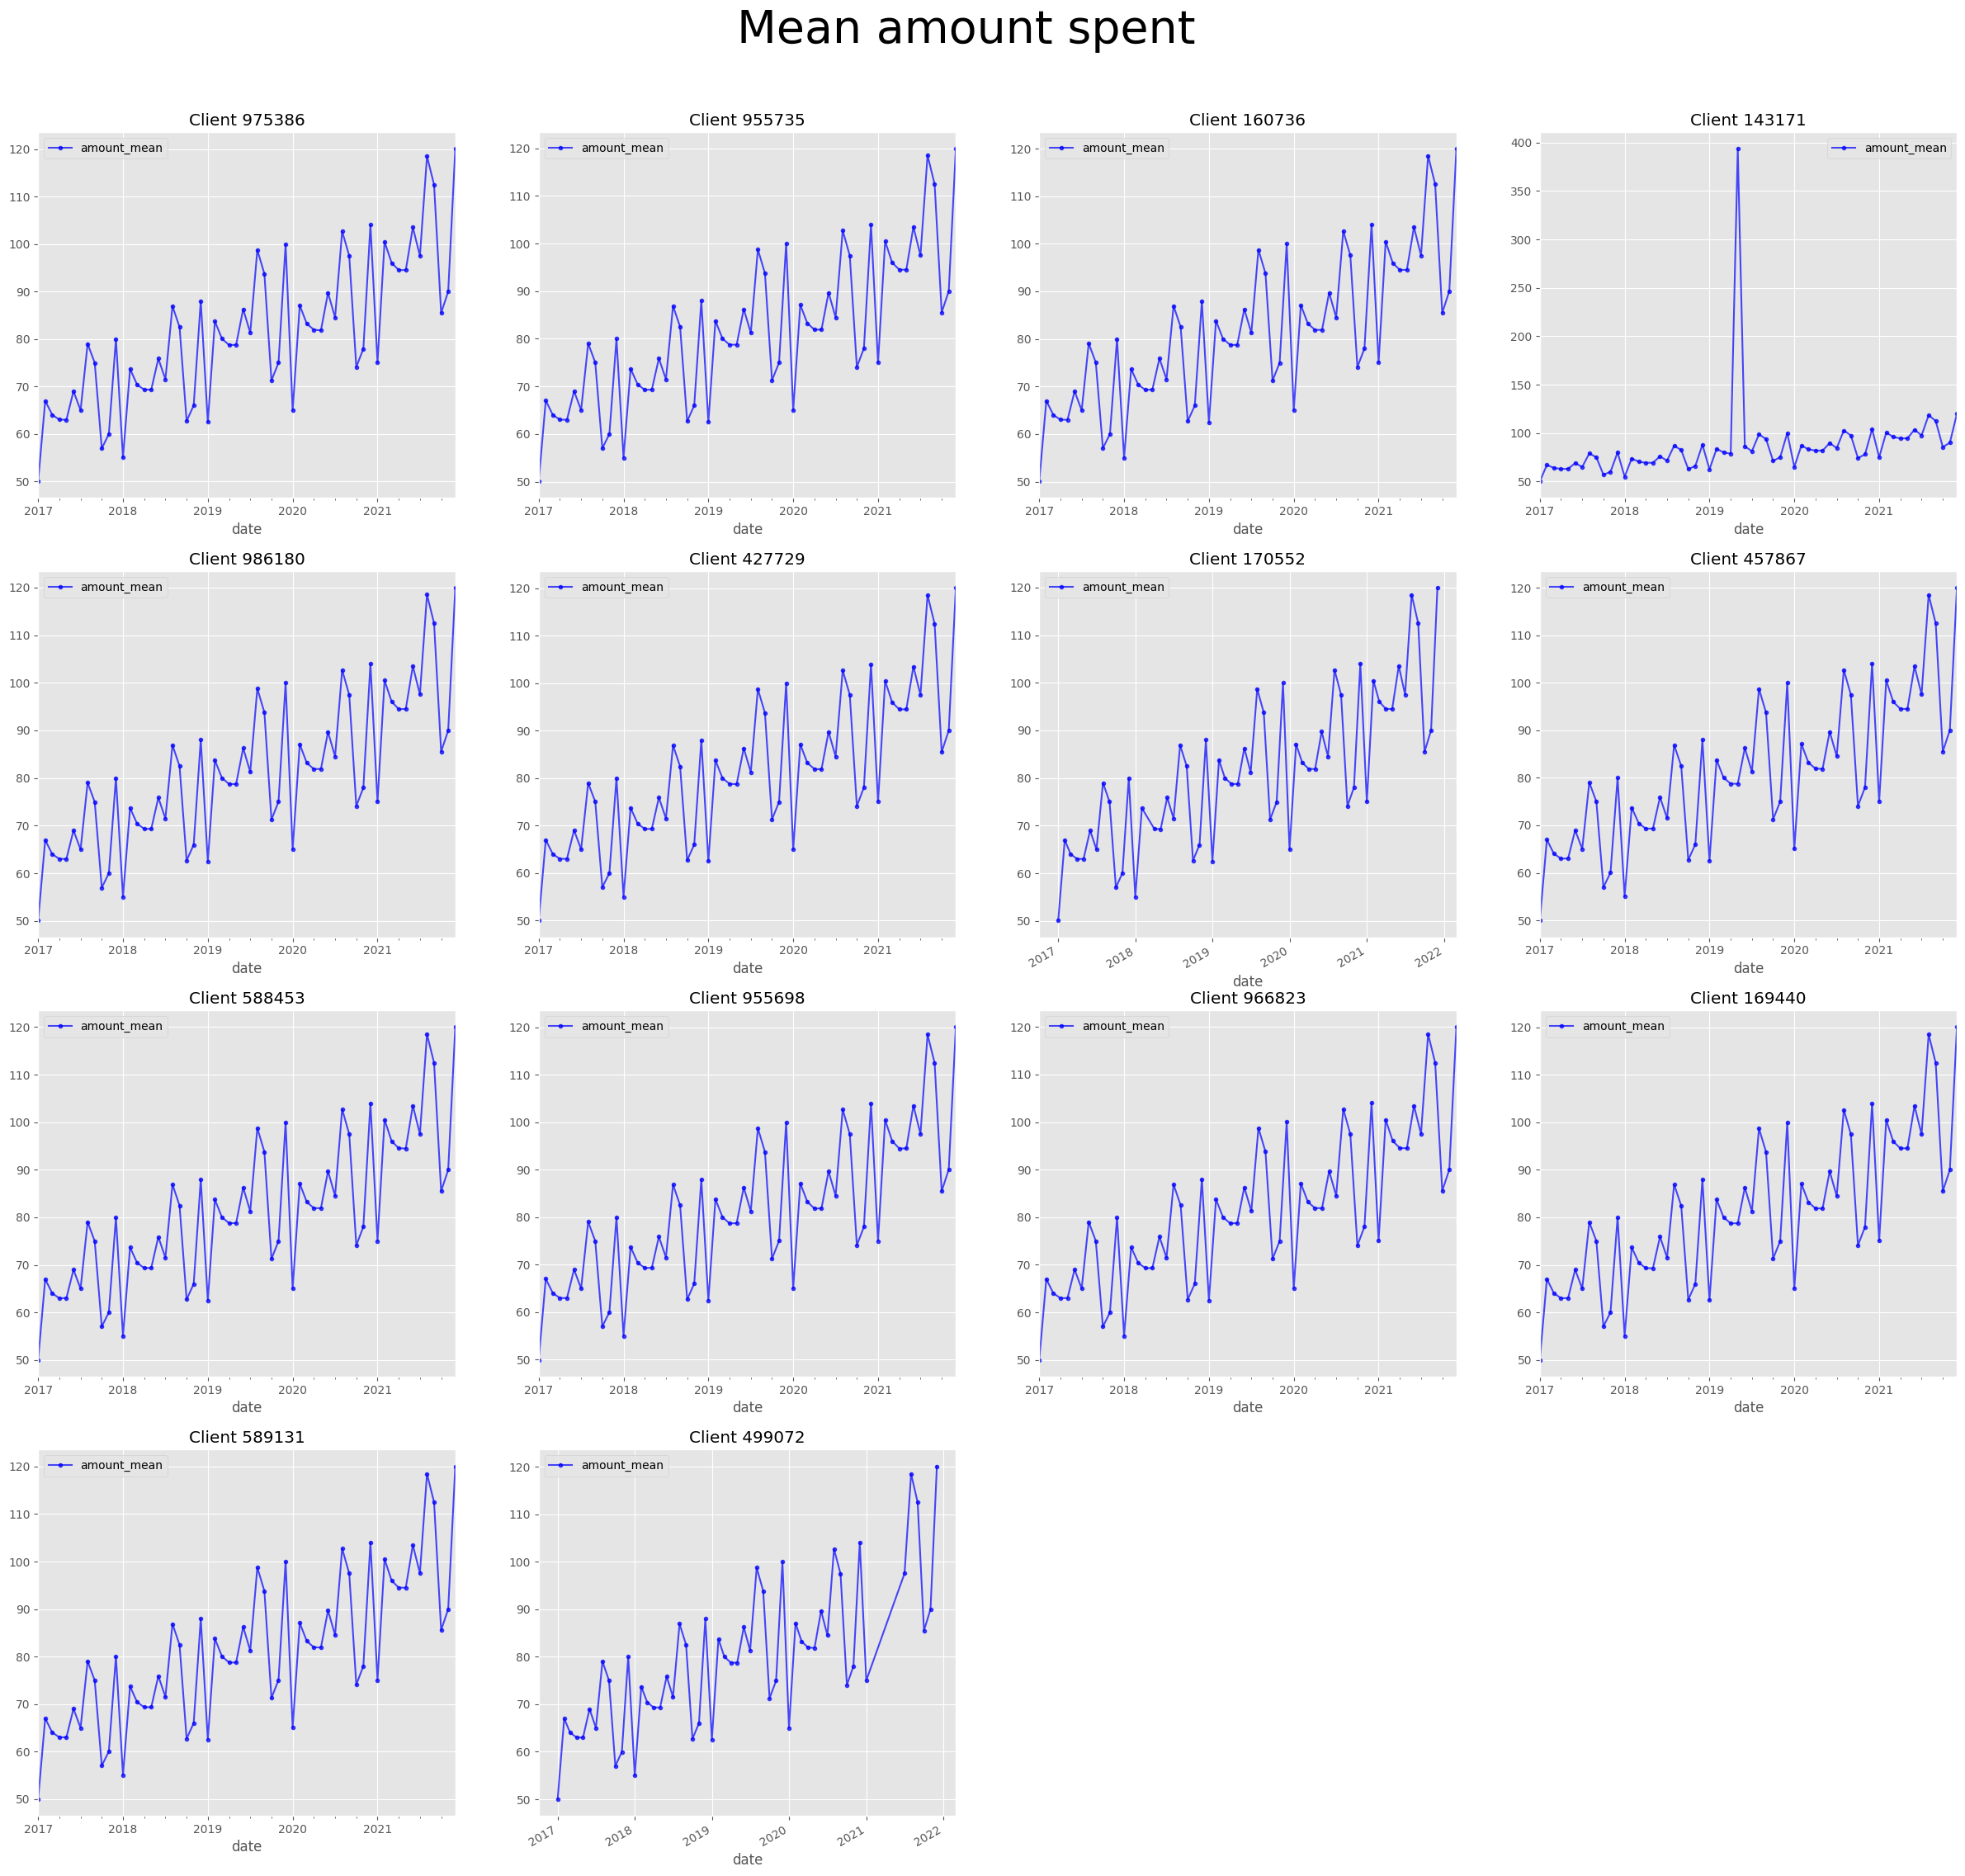

In [ ]:
fig, axes = plt.subplots(nrows= 4, ncols=4, figsize = (30,30))

for i, ax in enumerate(axes.flat):
    if i == n_clients:
        break
    df[df['client_id'] == clients[i]].plot(x= 'date', y= 'amount_mean', ax=ax, marker='.', color = 'b', alpha = 0.7)
    ax.set_title('Client {}'.format(clients[i]))

fig.delaxes(axes[3][3])
fig.delaxes(axes[3][2])
fig.suptitle('Mean amount spent', fontsize=40, y = 0.93)
plt.show()

<bound method FigureBase.delaxes of <Figure size 3000x3000 with 15 Axes>>

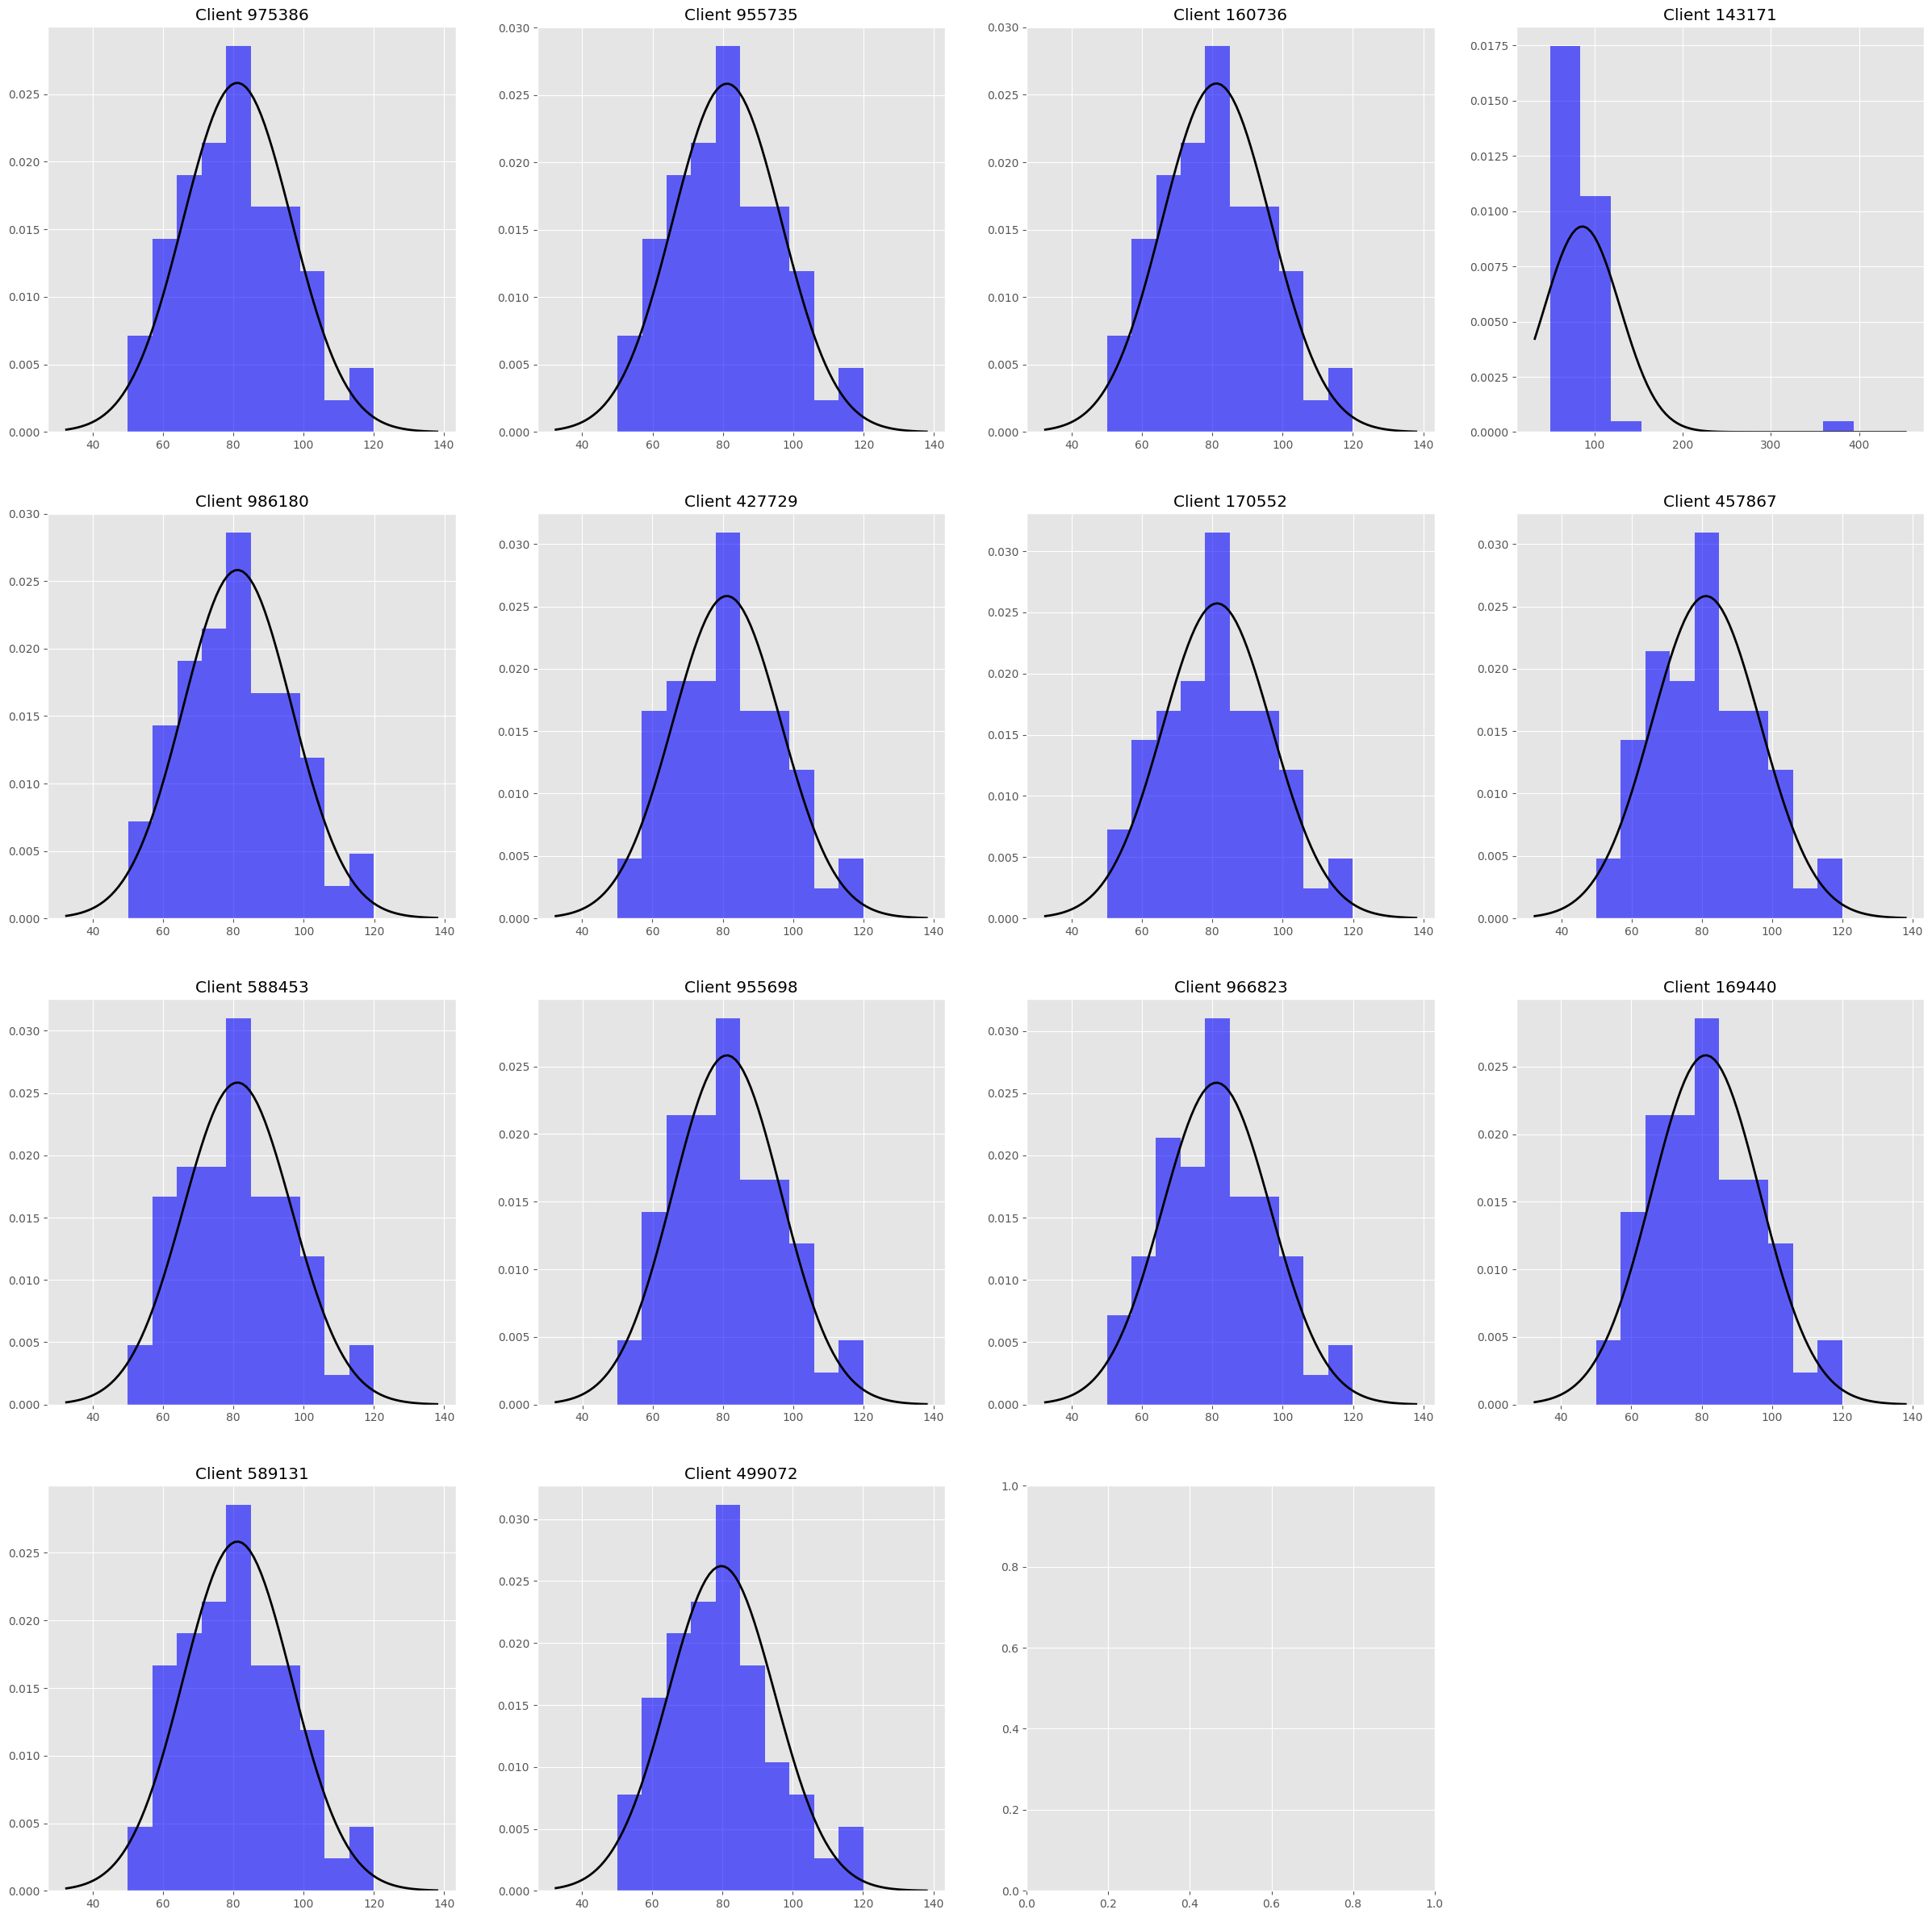

In [ ]:
fig, axes = plt.subplots(nrows= 4, ncols=4, figsize = (30,30))
plt.style.use('ggplot')

for i, ax in enumerate(axes.flat):
    if i == 14:
        break

    data_to_plot = df[df['client_id'] == clients[i]]['amount_mean']
    mu, std = norm.fit(data_to_plot)

    # Plot the histogram.
    ax.hist(data_to_plot, density=True, alpha=0.6, color='b')

    # Plot the PDF.
    x_min = min(data_to_plot) * 0.65
    x_max = max(data_to_plot) * 1.15
    x = np.linspace(x_min, x_max, 100)
    p = norm.pdf(x, mu, std)
    ax.plot(x, p, color = 'k', linewidth=2)
    ax.set_title(f'Client {clients[i]}')

fig.delaxes(axes[3][3])
fig.delaxes

In [ ]:
def detect_outliers(data, measure):
    """
    Returns which points of a pandas series fall beyond a given z-score threshold.

    Inputs:
    :data: pandas series from which identifying outliers.
    :measure: name of the pandas series in the dataframe it belongs to.

    Outputs:
    :outliers: list of identified outliers.

    """
    outliers = []
    threshold = 3
    mean = np.mean(data)
    std =np.std(data)

    for i in data:
        z_score = (i - mean)/std
        if np.abs(z_score) > threshold:
            outliers.append(df[df[measure] == i])
    if len(outliers) > 0:
        return outliers


for client in clients:

    current_client = df[df['client_id'] == client]
    # current_client = current_client.set_index('date')

    anomalies_spending = detect_outliers(current_client['amount_mean'], 'amount_mean')
    # anomalies_transactions = detect_outliers(current_client['amount_count'], 'amount_count')

    # # Anomalies in spending amount
    if anomalies_spending != None:
        print('Anomalies in spending amount'.center(50,'*'))
        for anomaly in anomalies_spending:
            print(anomaly)



***********Anomalies in spending amount***********
    client_id       date  amount_mean  amount_count
28     143171 2019-05-01   393.629502            30


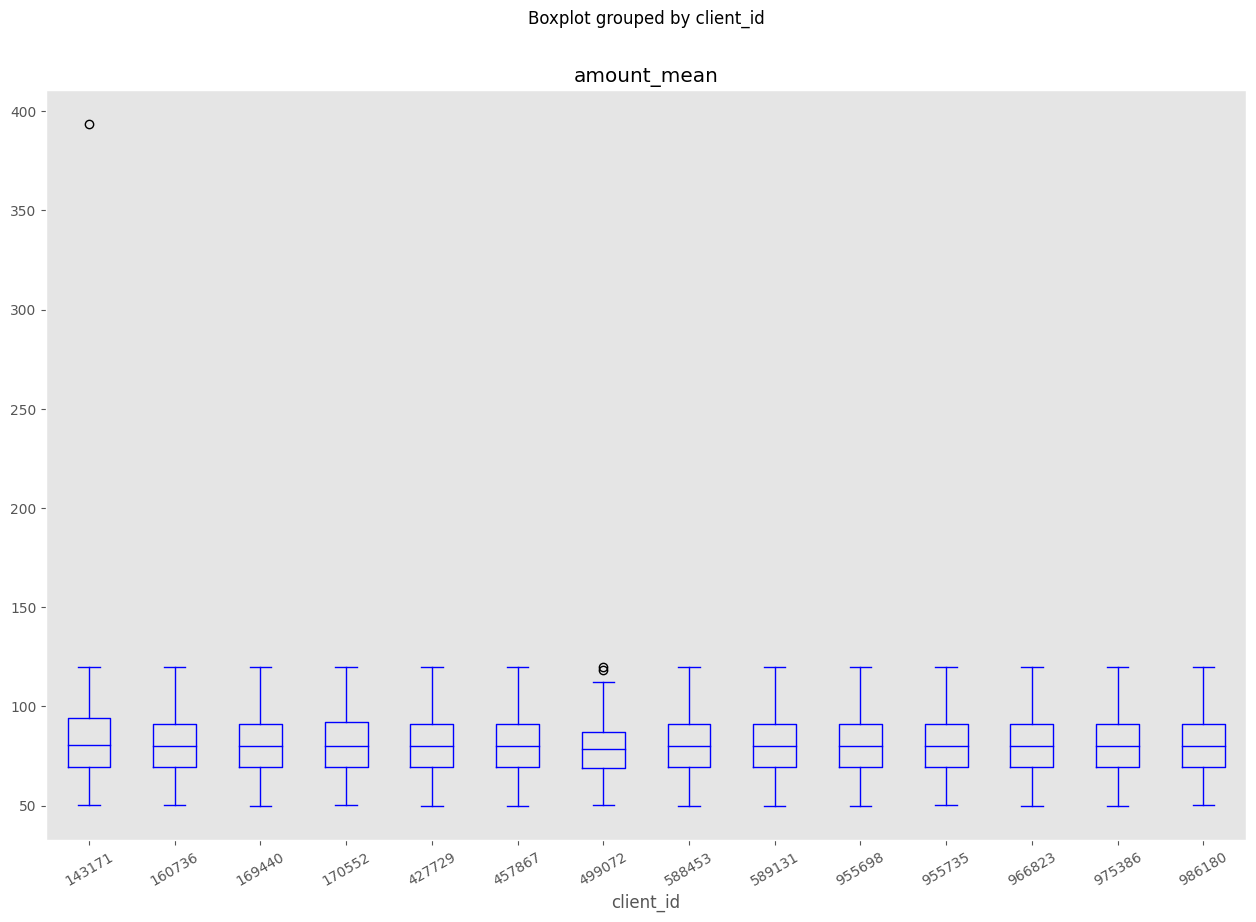

In [ ]:
boxplot = df.boxplot(column=['amount_mean'], by='client_id', grid = False, rot = 30, figsize=(15,10), color = 'b')
# boxplot = df.boxplot(column=['amount_count'], by='client_id', grid = False, rot = 30, figsize=(15,10))

In [ ]:
# Print anomalies with regard to spending amount
print("Anomalies with regard to spending amount".center(200,'*'))
for client in clients:
    current_client = df[df['client_id'] == client]
    Q1 = df['amount_mean'].quantile(0.25)
    Q3 = df['amount_mean'].quantile(0.75)
    IQR = Q3 - Q1

    filter = (current_client['amount_mean'] < Q1 - 1.5 * IQR) | (current_client['amount_mean'] > Q3 + 1.5 * IQR)
    # something going on with the boxplots becasue the two outliers for client 499072 are actually inside Q3 + 1.5*IQR,
    # if we replace 1.5 by 1.3 then we see them:
    # filter = (current_client['amount_mean'] < Q1 - 1.5 * IQR) | (current_client['amount_mean'] > Q3 + 1.3 * IQR)
    if filter.any():
        display(current_client.loc[filter])

# # Print anomalies with regard to number of transactions
# print("Anomalies with regard to number of transactions".center(200,'*'))
# for client in clients:
#     current_client = df[df['client_id'] == client]
#     Q1 = df['amount_count'].quantile(0.25)
#     Q3 = df['amount_count'].quantile(0.75)
#     IQR = Q3 - Q1

#     filter = ((current_client['amount_count'] < Q1 - 1.5 * IQR) | (current_client['amount_count'] > Q3 + 1.5 * IQR))
#     if filter.any():
#         display(current_client.loc[filter])

********************************************************************************Anomalies with regard to spending amount********************************************************************************


client_id       date  amount_mean  amount_count
28     143171 2019-05-01   393.629502            30

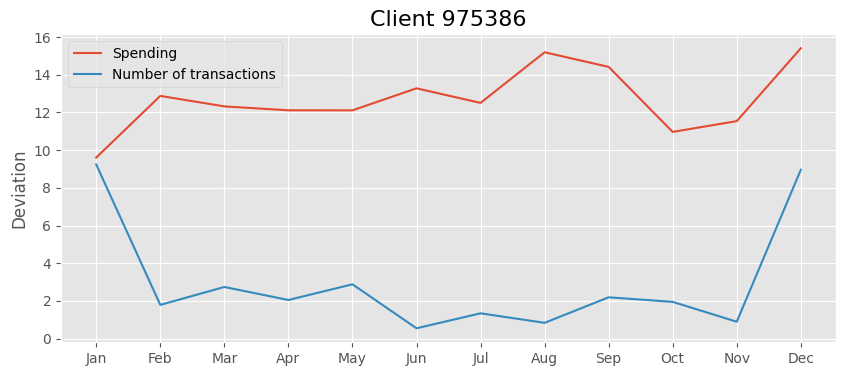

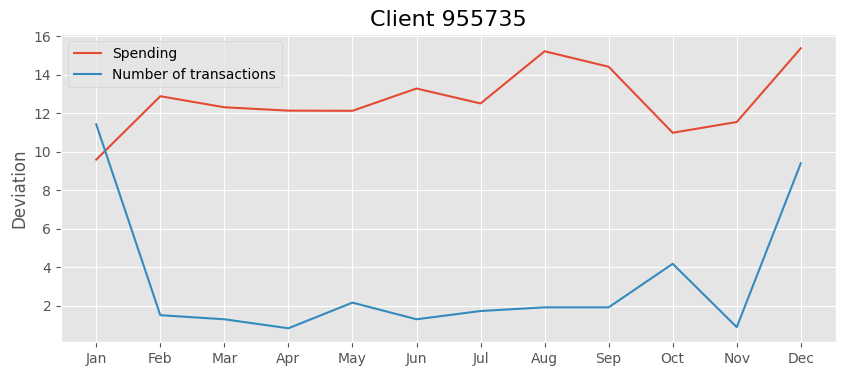

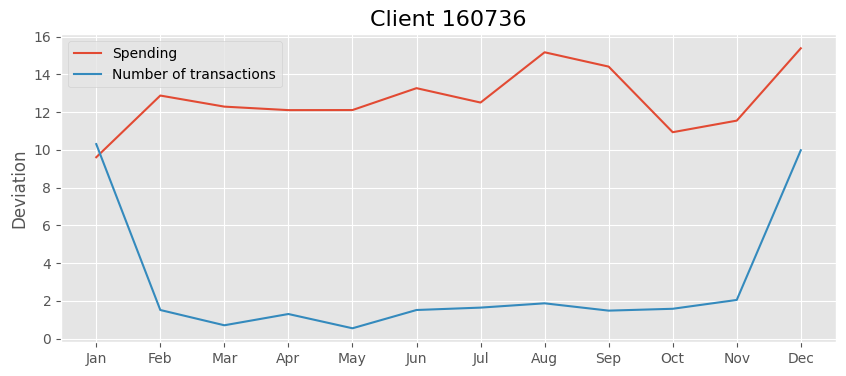

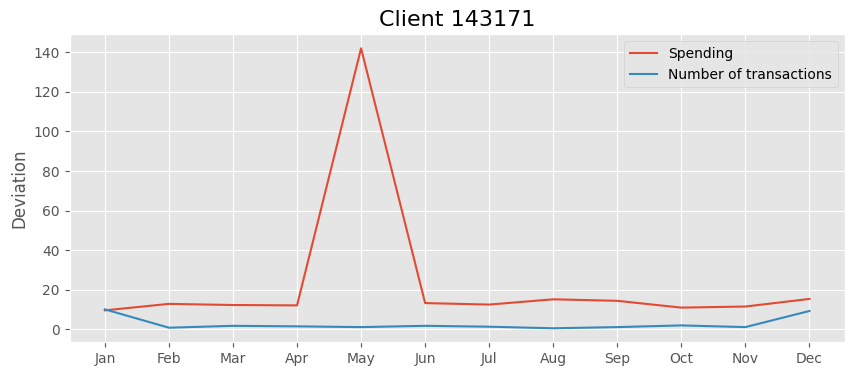

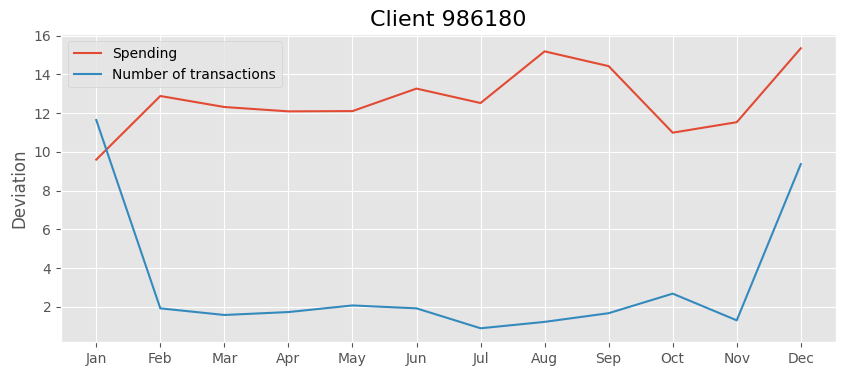

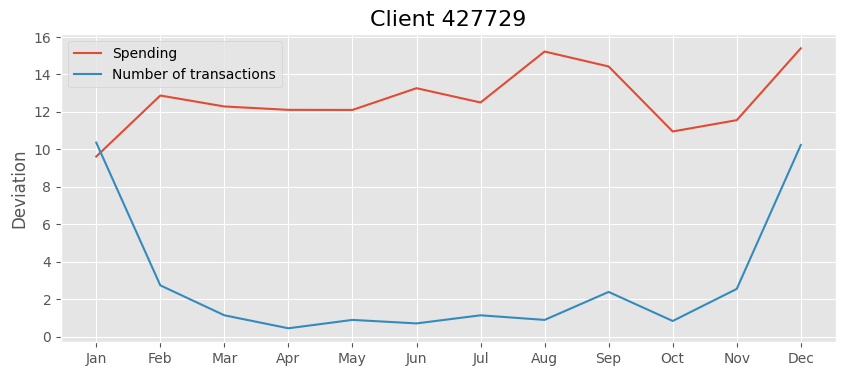

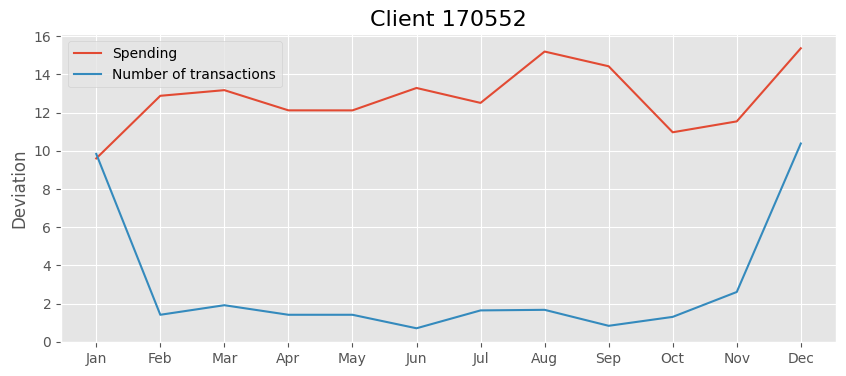

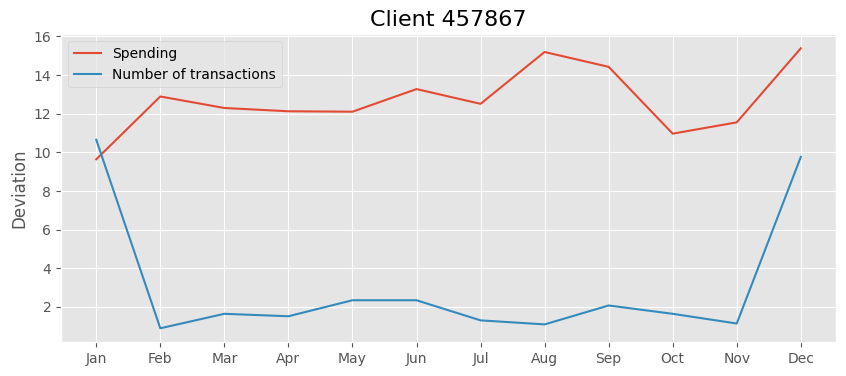

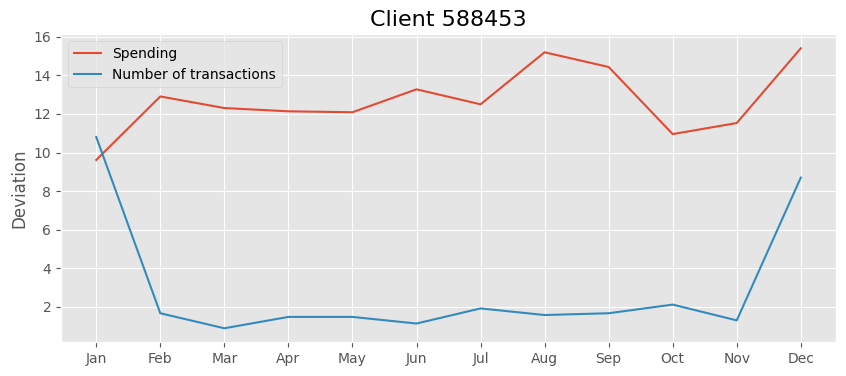

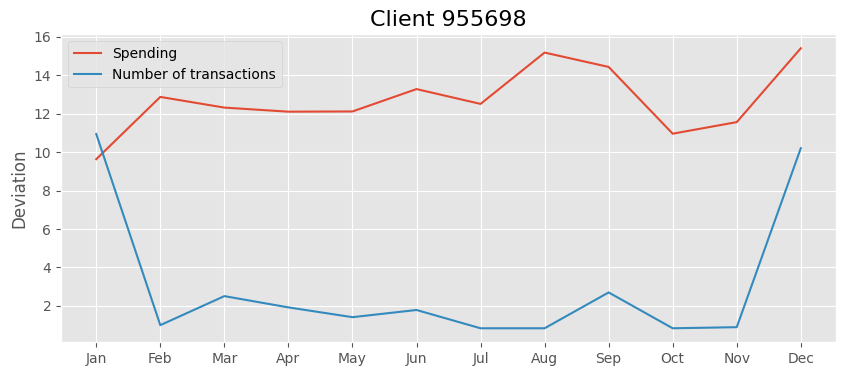

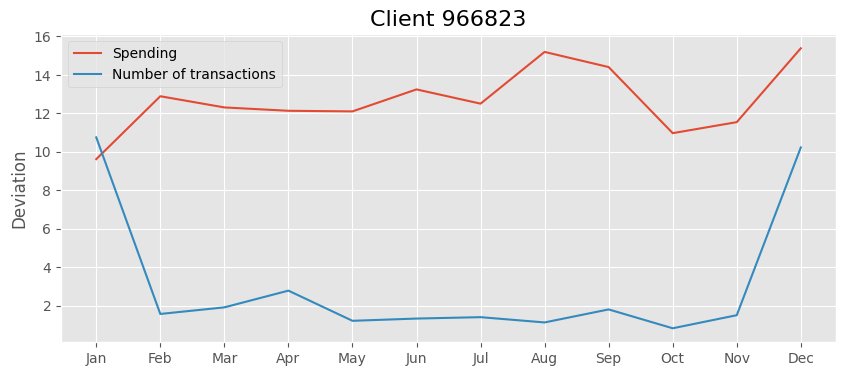

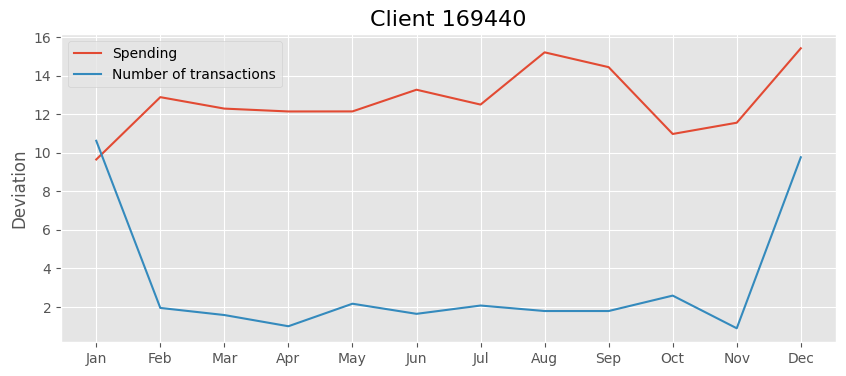

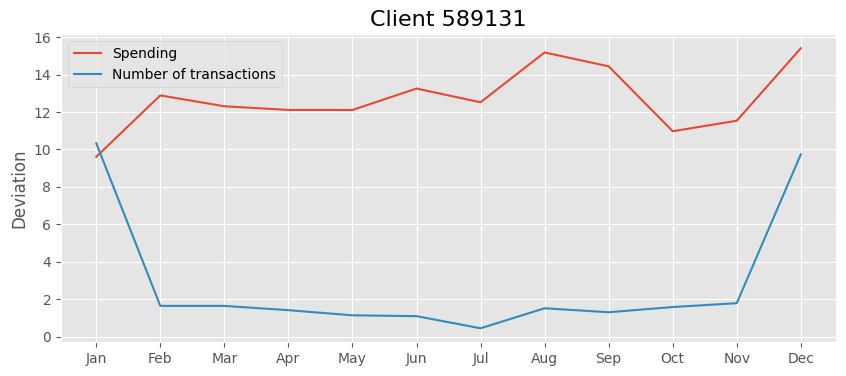

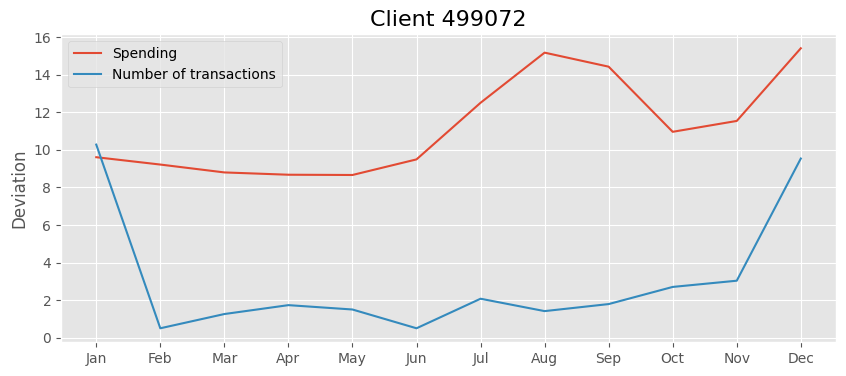

In [ ]:
for client in clients:
    current_client = df[df['client_id'] == client]
    month_deviations_spending = current_client.groupby(by=[current_client.date.dt.month], as_index = False).agg(deviations = ('amount_mean', 'std'))
    month_deviations_transactions = current_client.groupby(by=[current_client.date.dt.month], as_index = False).agg(deviations = ('amount_count', 'std'))

    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    xi = list(range(len(months)))

    plt.figure(figsize=(10,4))
    plt.style.use('ggplot')
    plt.plot(month_deviations_spending, label = 'Spending')
    plt.plot(month_deviations_transactions, label = 'Number of transactions')
    plt.title(f'Client {client}', fontsize=16)
    plt.ylabel('Deviation', fontsize=12)
    plt.xticks(xi, months)
    plt.legend()

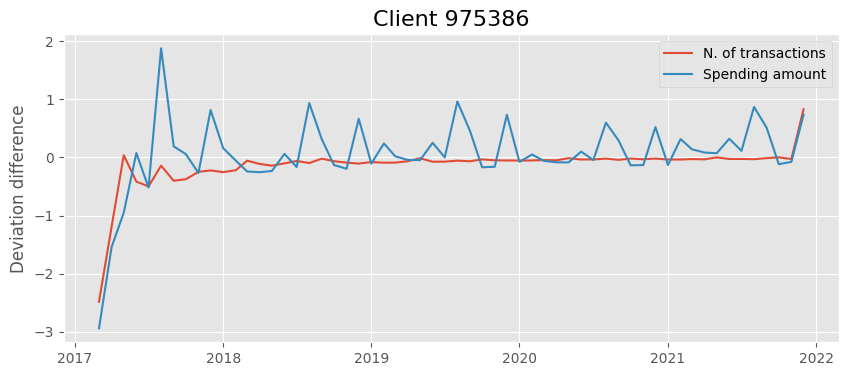

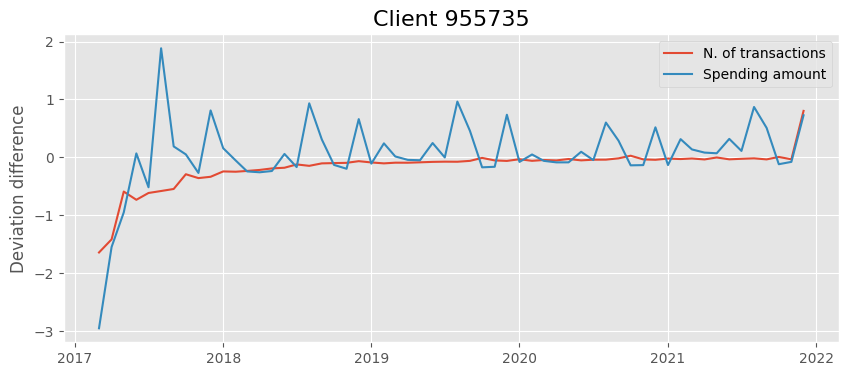

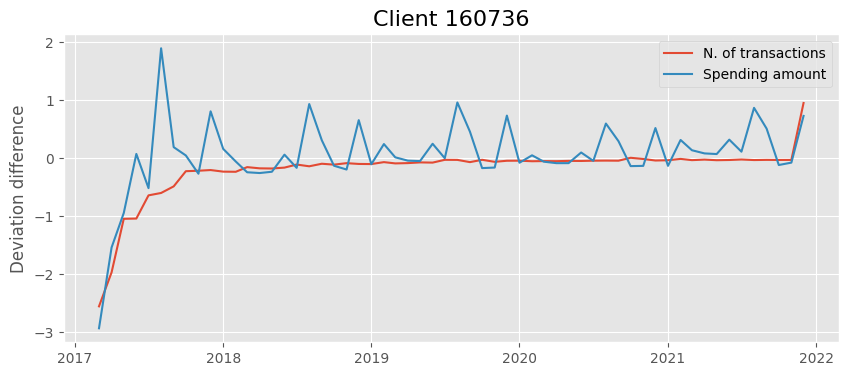

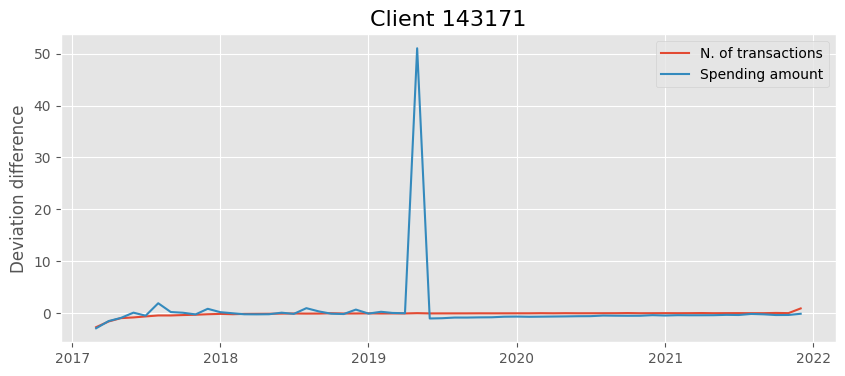

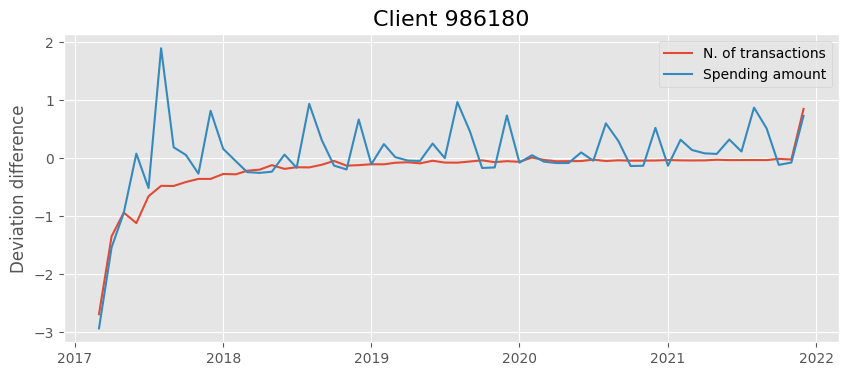

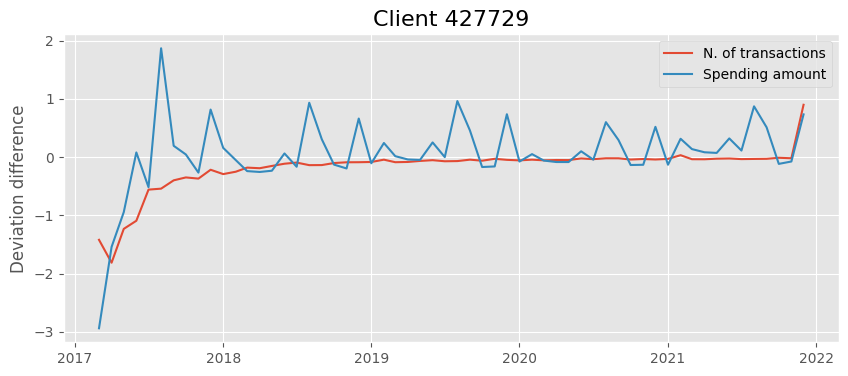

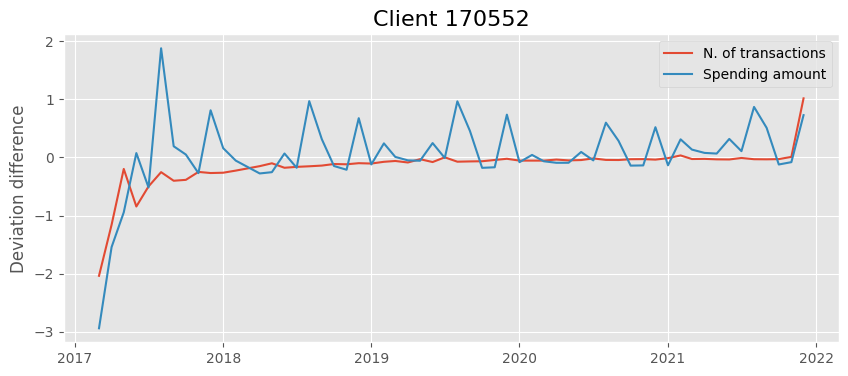

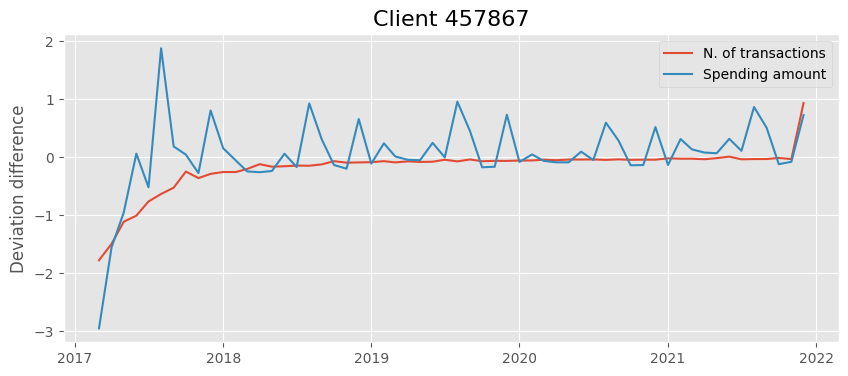

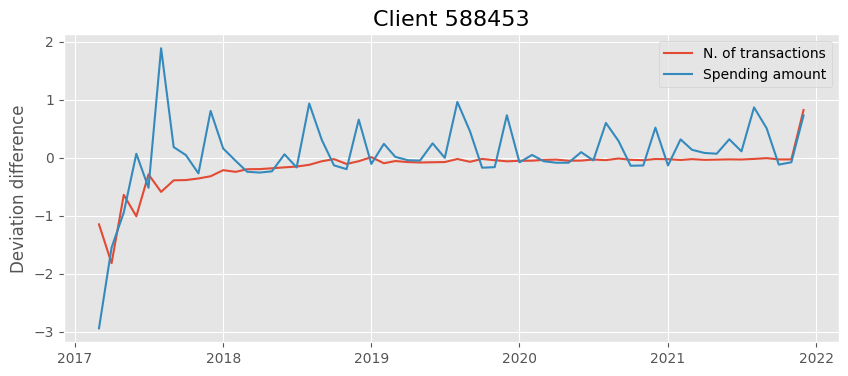

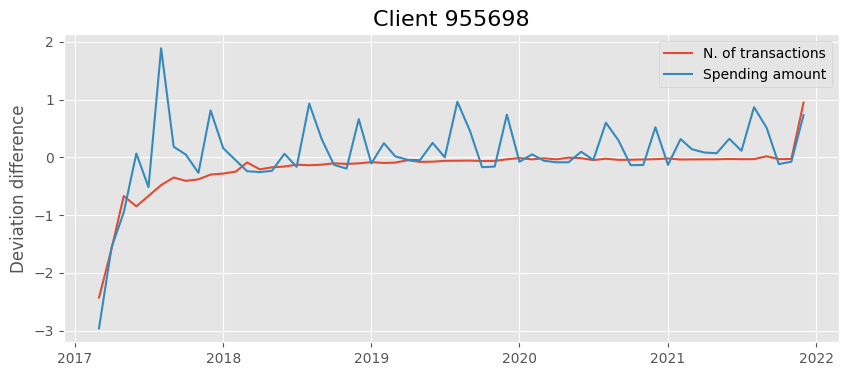

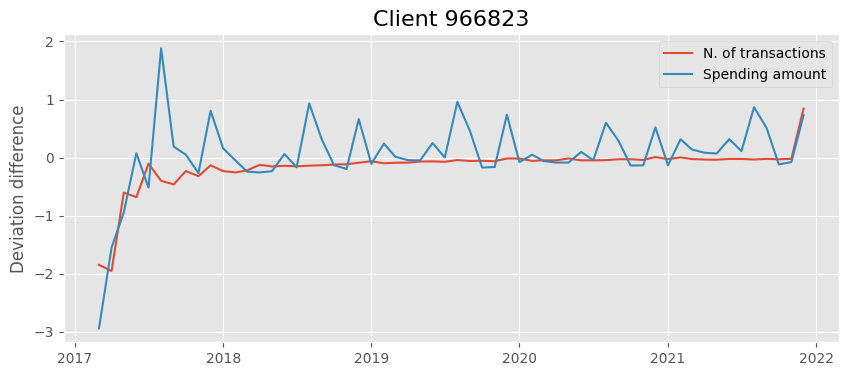

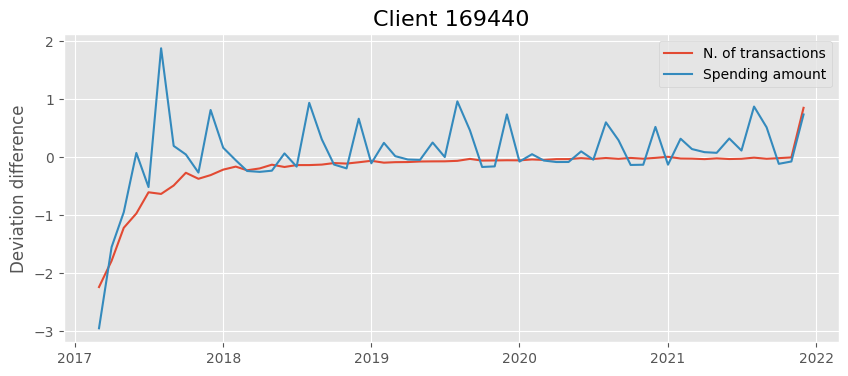

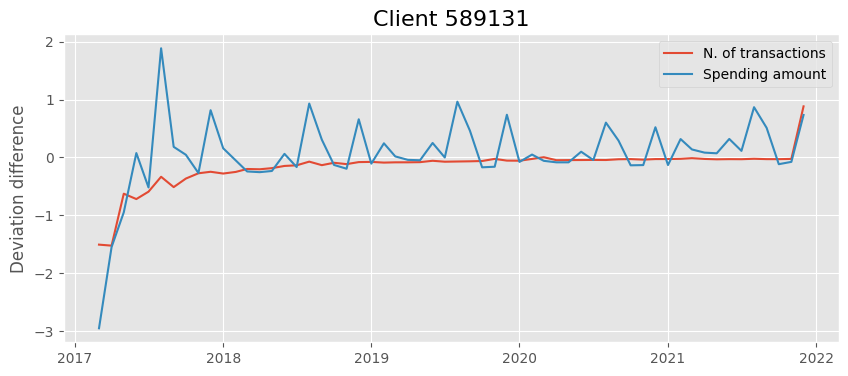

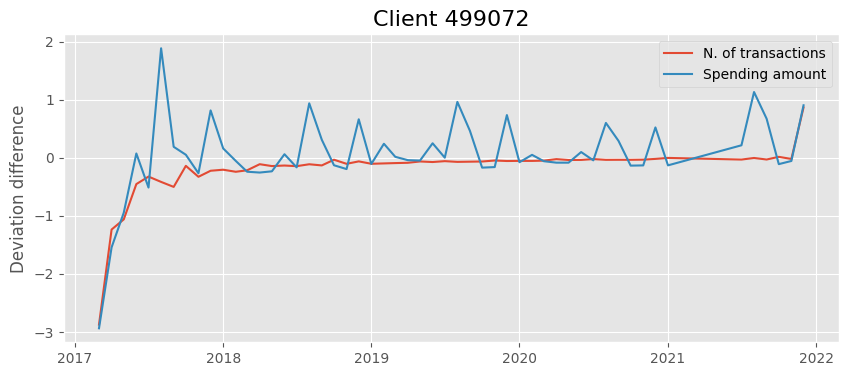

In [ ]:
for client in clients:
    current_client = df[df['client_id'] == client]

    rolling_deviations_spend = pd.Series(dtype=float, index = current_client.index)
    rolling_deviations_transact = pd.Series(dtype=float, index = current_client.index)

    for date in rolling_deviations_spend.index:
        #get the window ending at this data point
        window_s = current_client['amount_mean'].loc[:date]
        window_t = current_client['amount_count'].loc[:date]

        #get the deviation within this window
        rolling_deviations_spend.loc[date] = window_s.std()
        rolling_deviations_transact.loc[date] = window_t.std()


    #get the difference in deviation between one time point and the next
    diff_rolling_deviations_s = rolling_deviations_spend.diff()
    diff_rolling_deviations_s = diff_rolling_deviations_s.dropna()

    diff_rolling_deviations_t = rolling_deviations_transact.diff()
    diff_rolling_deviations_t = diff_rolling_deviations_t.dropna()


    plt.figure(figsize=(10,4))
    plt.plot(current_client.date[2:], diff_rolling_deviations_t.iloc[:], label = "N. of transactions")
    plt.plot(current_client.date[2:], diff_rolling_deviations_s,  label = "Spending amount")
    plt.title(f'Client {client}', fontsize=16)
    plt.ylabel('Deviation difference', fontsize=12)
    plt.legend()

In [ ]:
def find_anomalies(current_client, resid, client):
    """
    Calculates outliers from residuals of a time series. First identifies which residuals lie beyond
    3 std, then identifies which residuals fall outside 1.5 IQR. Prints and plots the identified ouliers.

    Inputs:
    :current_client: Pandas series corresponding to one client's mean spending amount. Index is the date
    :resid: Pandas series of resiudals extracted from the fit of current_client to an STL model.
    :client: client number corresponding to the current_client series.
    """


    # calculate needed quantities for z-score analysis of residuals
    resid_mu = resid.mean()
    resid_dev = resid.std()
    lower = resid_mu - 3*resid_dev
    upper = resid_mu + 3*resid_dev

    # calculate needed quantities for IQR analysis of residuals
    Q1 = resid.quantile(0.25)
    Q3 = resid.quantile(0.75)
    IQR = Q3 - Q1
    lower_iqr = Q1 - 1.5 * IQR
    upper_iqr = Q3 + 1.5 * IQR


    # Plot residuals with confidence band
    plt.figure(figsize=(10,4))
    plt.style.use('ggplot')
    plt.plot(resid, marker='.', color = 'b', alpha = 0.75)

    plt.fill_between([dt(2017,1,1), dt(2021,12,1)], lower, upper, color='g',
                     alpha=0.2, linestyle='--', linewidth=2, label= "z-score" )
    plt.fill_between([dt(2017,1,1), dt(2021,12,1)], lower_iqr, upper_iqr,
                     color='g', alpha=0.3, linestyle='--', linewidth=2, label= "IQR")
    # plt.text(dt(2017,4,1), 1.1*upper_iqr, "IQR", ha='center', va='center', fontsize=12, color='crimson')
    # plt.text(dt(2017,4,1), 1.05*upper, "z-score", ha='center', va='center', fontsize=12, color='crimson')
    plt.title(f"Client {client}")
    plt.legend()

    print("#".center(50, '#'))
    print(f" Client {client} ".center(50, '#'))
    print("#".center(50, '#'))


    # print anomalies found with z-score
    anomalies = current_client[(resid < lower) | (resid > upper)]
    print("Anomalies found with z-score".center(50,'*'))
    display(anomalies)


    # print anomalies found with IQR
    filter = (resid < Q1 - 1.5 * IQR) | (resid > Q3 + 1.5 * IQR)
    print("Anomalies found with IQR".center(50,'*'))
    if filter.any():
        display(current_client.loc[filter])


    # Plot data with identified residuals
    plt.figure(figsize=(10,4))
    plt.plot(current_client.index, current_client.iloc[:], marker='.',
             color = 'b', alpha = 0.75)
    plt.scatter(current_client.loc[filter].index, current_client.loc[filter].iloc[:],
                s = 120, color='r', marker='*', alpha = 0.8, label = "IQR")
    plt.scatter(anomalies.index, anomalies.iloc[:], s = 120, color='lime',
                marker='*', alpha = 0.7, label = "z-score and IQR")
    plt.title(f"Client {client}")
    plt.legend()
    plt.show()

##################################################
################# Client 975386 ##################
##################################################
***********Anomalies found with z-score***********


date
2019-12-01    99.951757
Name: amount_mean, dtype: float64

*************Anomalies found with IQR*************


date
2019-12-01    99.951757
2020-02-01    87.082803
Name: amount_mean, dtype: float64

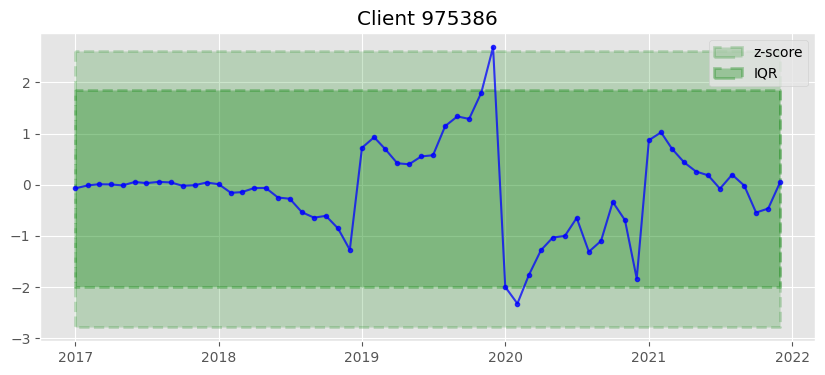

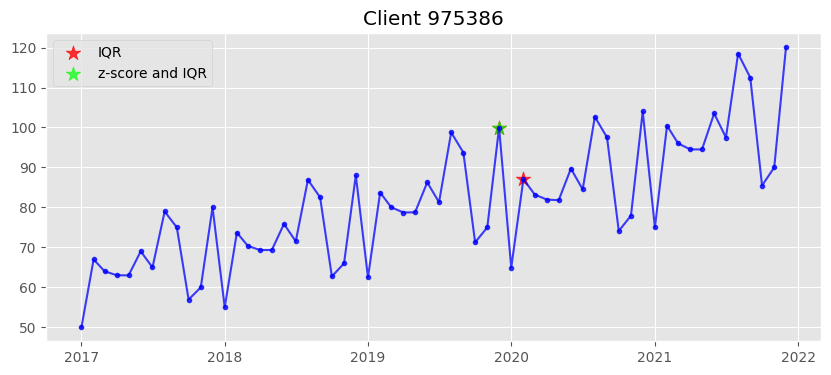

##################################################
################# Client 955735 ##################
##################################################
***********Anomalies found with z-score***********


date
2019-12-01    99.996159
Name: amount_mean, dtype: float64

*************Anomalies found with IQR*************


date
2019-12-01    99.996159
2020-02-01    87.129594
Name: amount_mean, dtype: float64

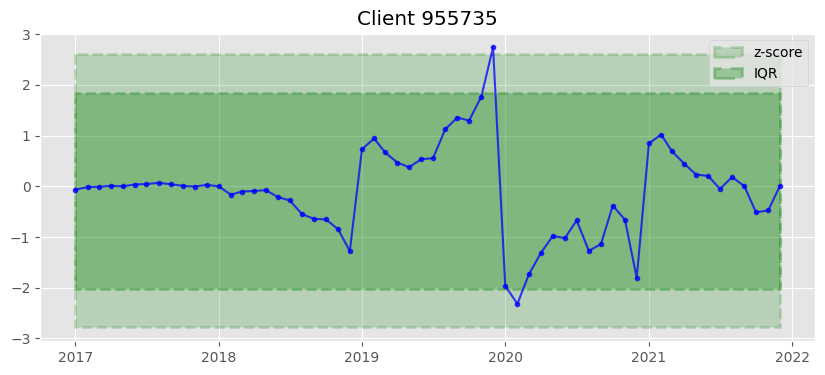

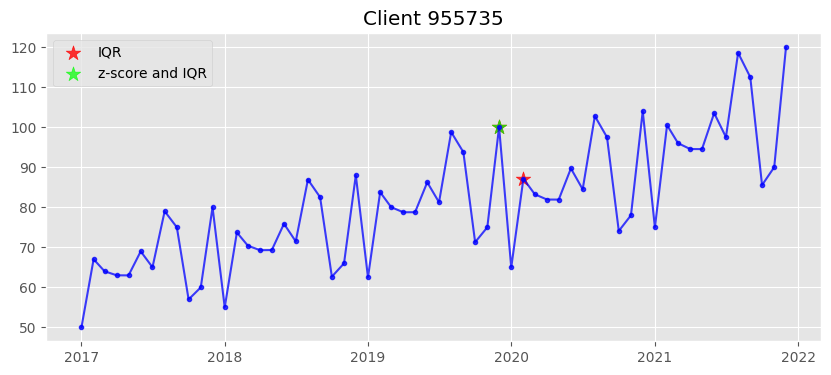

##################################################
################# Client 160736 ##################
##################################################
***********Anomalies found with z-score***********


date
2019-12-01    99.989454
Name: amount_mean, dtype: float64

*************Anomalies found with IQR*************


date
2019-12-01    99.989454
2020-02-01    87.102976
Name: amount_mean, dtype: float64

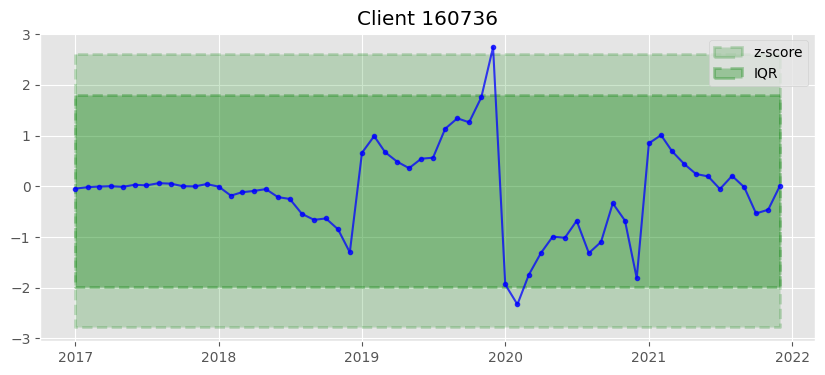

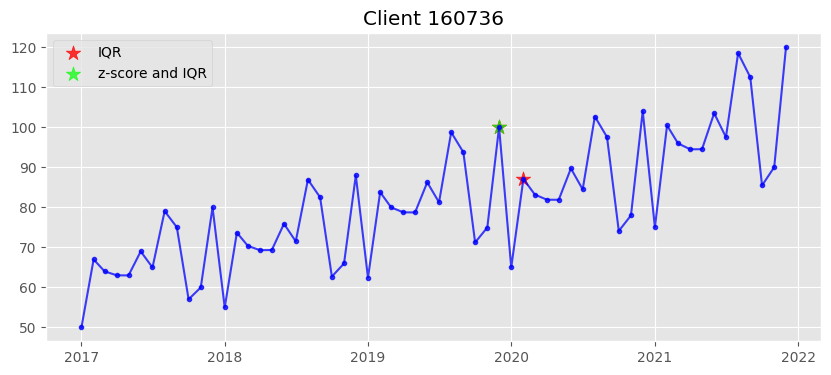

##################################################
################# Client 143171 ##################
##################################################
***********Anomalies found with z-score***********


date
2019-05-01    393.629502
Name: amount_mean, dtype: float64

*************Anomalies found with IQR*************


date
2017-05-01     62.980939
2018-05-01     69.334119
2019-05-01    393.629502
2020-05-01     81.870210
2021-05-01     94.510483
Name: amount_mean, dtype: float64

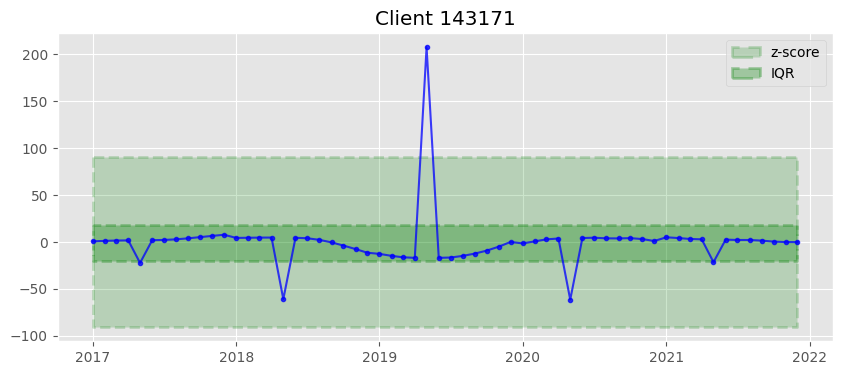

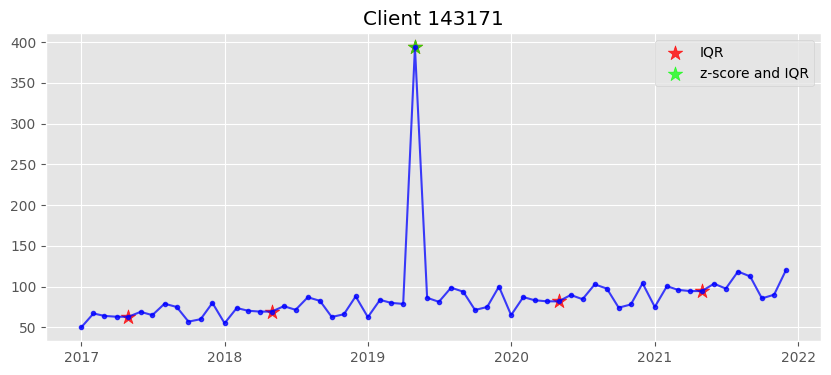

##################################################
################# Client 986180 ##################
##################################################
***********Anomalies found with z-score***********


date
2019-12-01    99.973044
Name: amount_mean, dtype: float64

*************Anomalies found with IQR*************


date
2019-12-01    99.973044
2020-02-01    87.099877
Name: amount_mean, dtype: float64

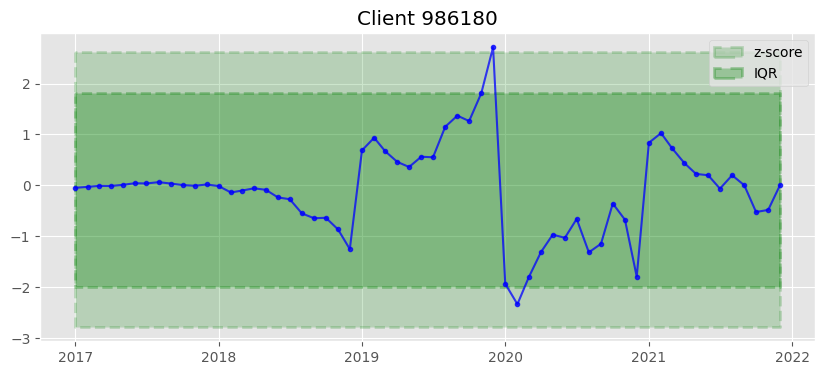

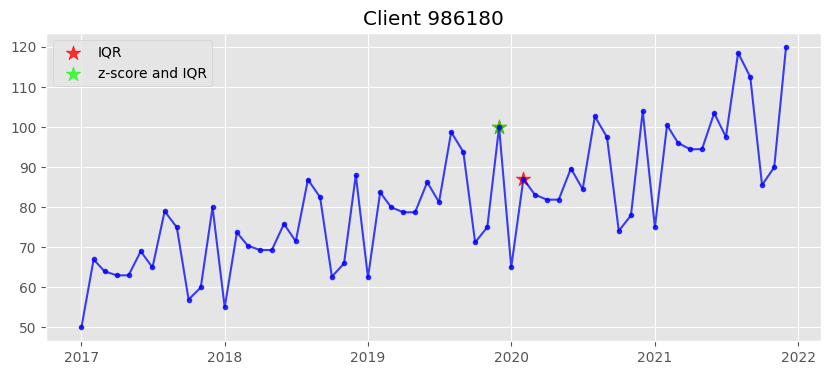

##################################################
################# Client 427729 ##################
##################################################
***********Anomalies found with z-score***********


date
2019-12-01    99.986198
Name: amount_mean, dtype: float64

*************Anomalies found with IQR*************


date
2019-12-01    99.986198
2020-01-01    64.966645
2020-02-01    87.116535
Name: amount_mean, dtype: float64

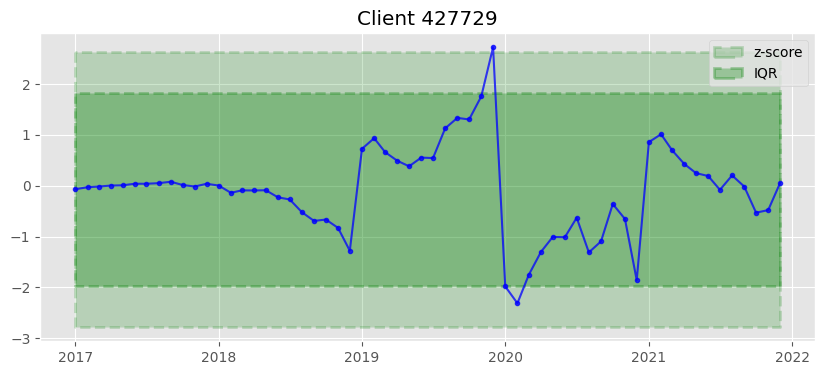

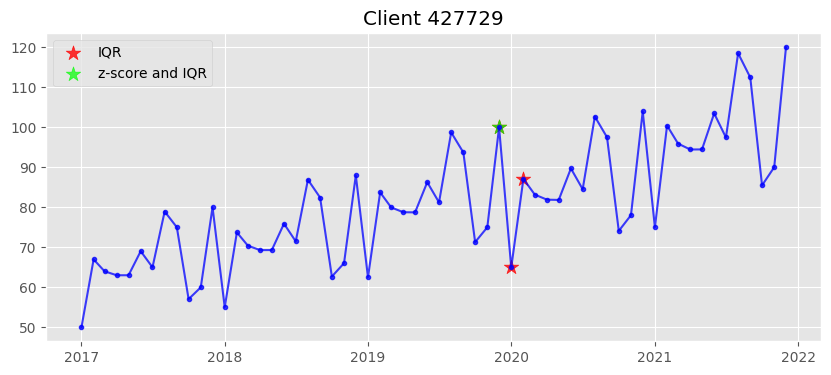

##################################################
################# Client 170552 ##################
##################################################
***********Anomalies found with z-score***********


Series([], Name: amount_mean, dtype: float64)

*************Anomalies found with IQR*************


date
2017-09-01    75.007041
2017-11-01    60.027616
2017-12-01    79.985377
2018-01-01    55.017122
2018-08-01    86.890768
2018-10-01    62.689813
2018-12-01    88.010196
2019-01-01    62.510889
2019-02-01    83.763060
2019-12-01    99.977995
Name: amount_mean, dtype: float64

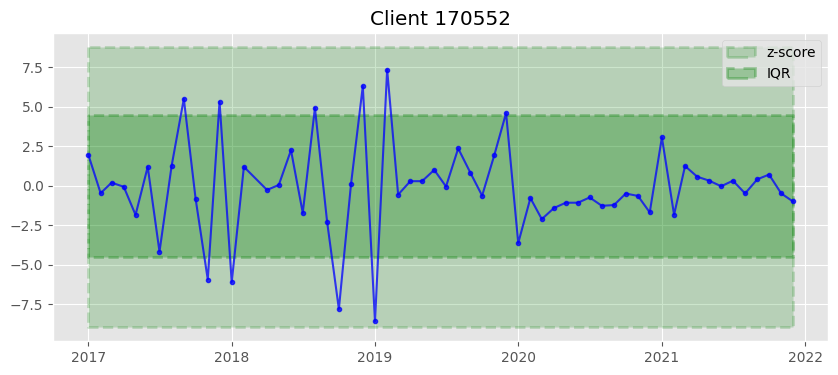

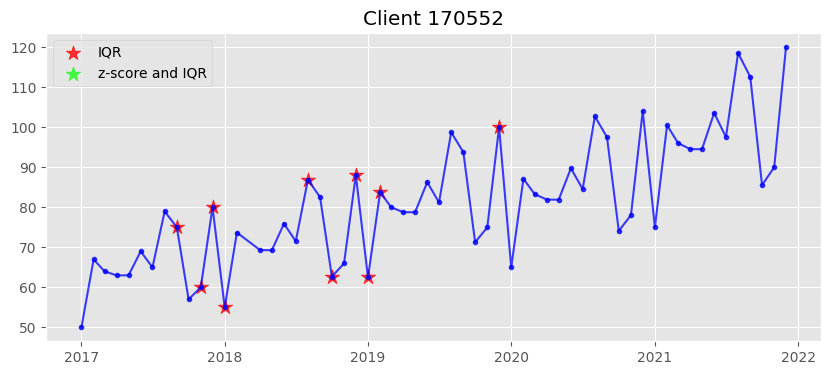

##################################################
################# Client 457867 ##################
##################################################
***********Anomalies found with z-score***********


date
2019-12-01    99.990255
Name: amount_mean, dtype: float64

*************Anomalies found with IQR*************


date
2019-12-01    99.990255
2020-02-01    87.133130
Name: amount_mean, dtype: float64

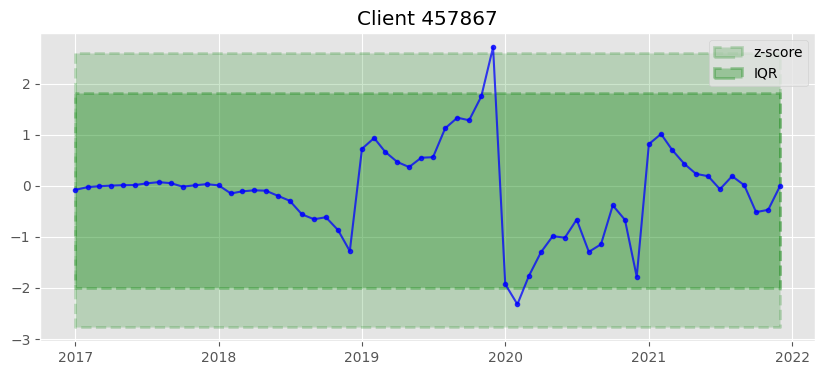

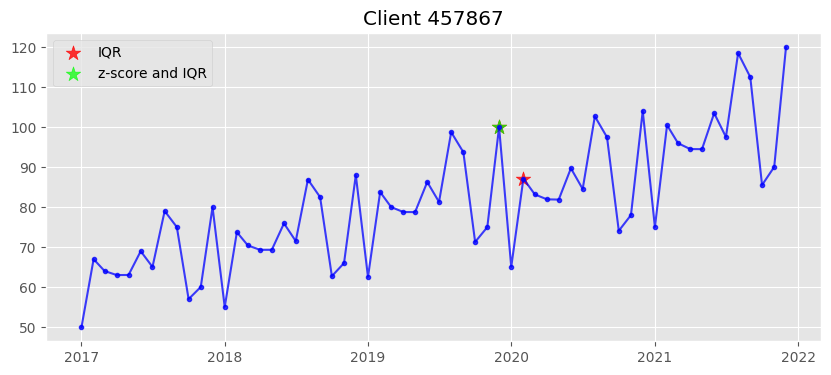

##################################################
################# Client 588453 ##################
##################################################
***********Anomalies found with z-score***********


date
2019-12-01    99.960967
Name: amount_mean, dtype: float64

*************Anomalies found with IQR*************


date
2019-12-01    99.960967
2020-02-01    87.086437
Name: amount_mean, dtype: float64

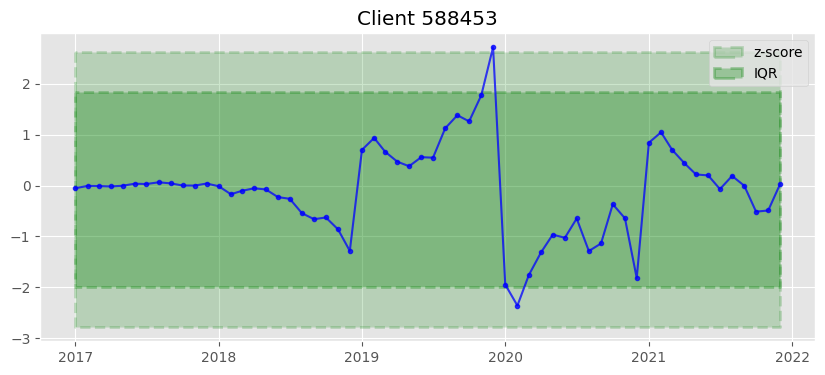

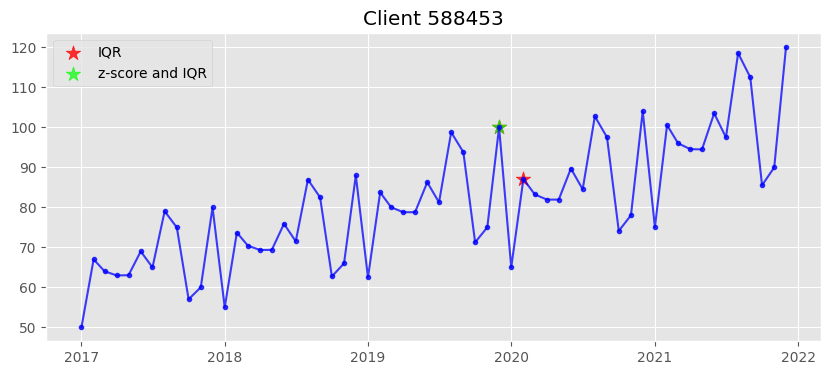

##################################################
################# Client 955698 ##################
##################################################
***********Anomalies found with z-score***********


date
2019-12-01    100.034268
Name: amount_mean, dtype: float64

*************Anomalies found with IQR*************


date
2019-12-01    100.034268
2020-02-01     87.143776
Name: amount_mean, dtype: float64

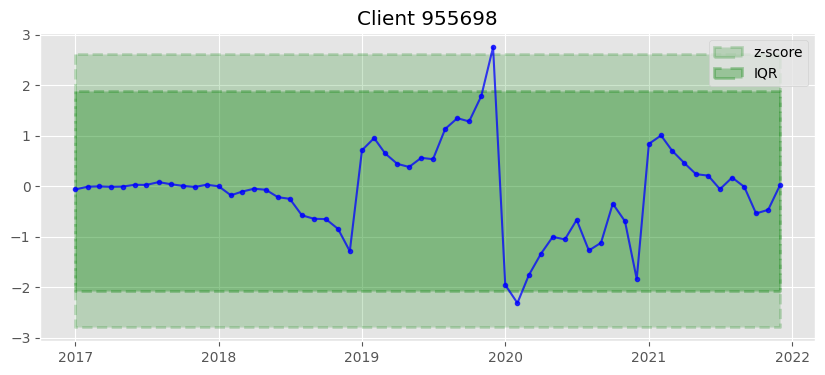

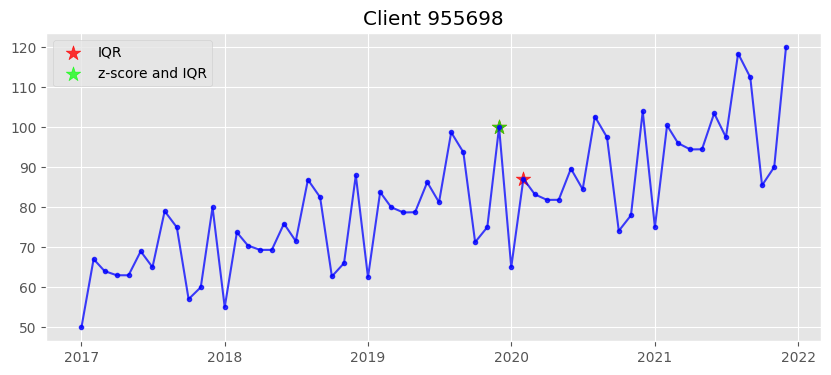

##################################################
################# Client 966823 ##################
##################################################
***********Anomalies found with z-score***********


date
2019-12-01    100.03622
Name: amount_mean, dtype: float64

*************Anomalies found with IQR*************


date
2019-12-01    100.036220
2020-02-01     87.110353
Name: amount_mean, dtype: float64

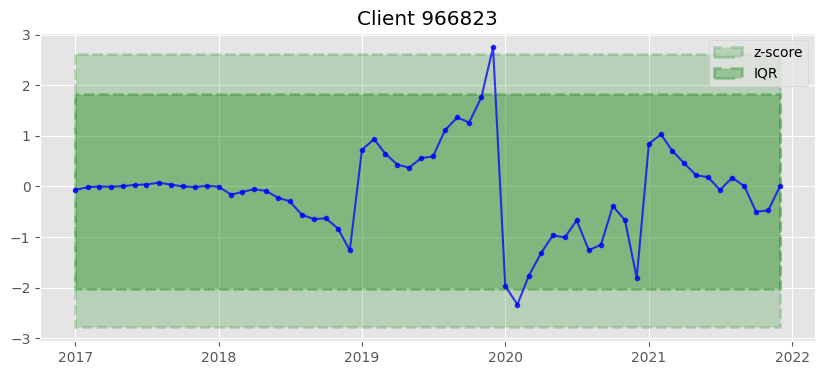

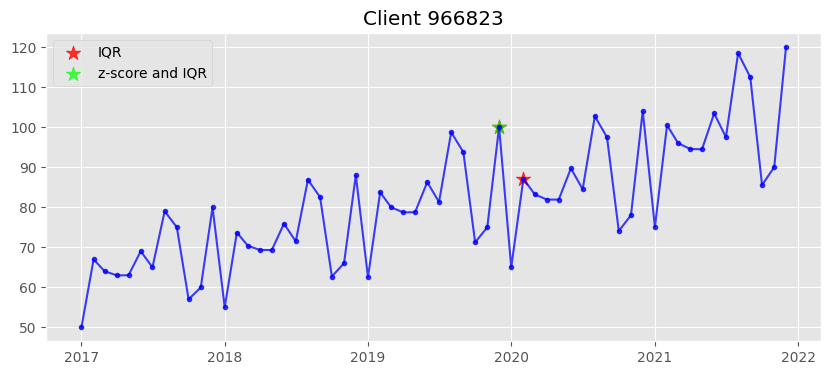

##################################################
################# Client 169440 ##################
##################################################
***********Anomalies found with z-score***********


date
2019-12-01    99.9929
Name: amount_mean, dtype: float64

*************Anomalies found with IQR*************


date
2019-12-01    99.99290
2020-02-01    87.07727
Name: amount_mean, dtype: float64

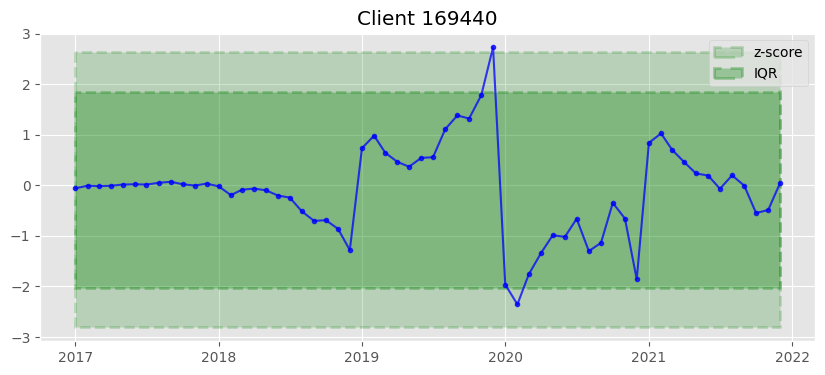

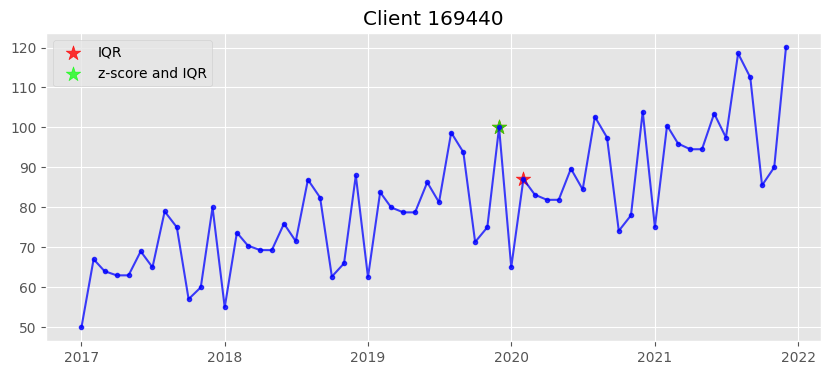

##################################################
################# Client 589131 ##################
##################################################
***********Anomalies found with z-score***********


date
2019-12-01    100.004077
Name: amount_mean, dtype: float64

*************Anomalies found with IQR*************


date
2019-12-01    100.004077
2020-02-01     87.084100
Name: amount_mean, dtype: float64

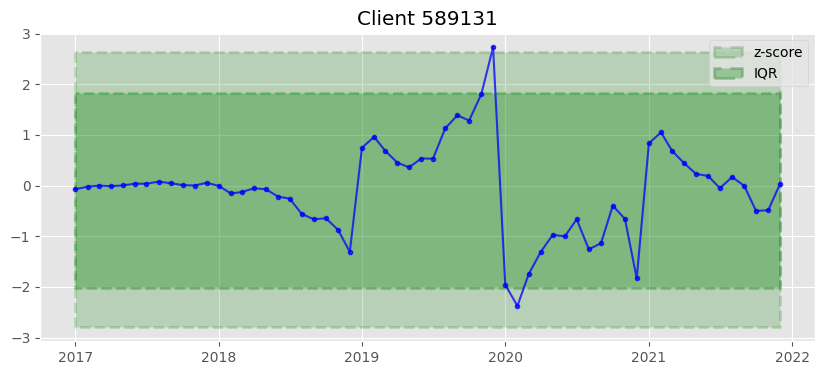

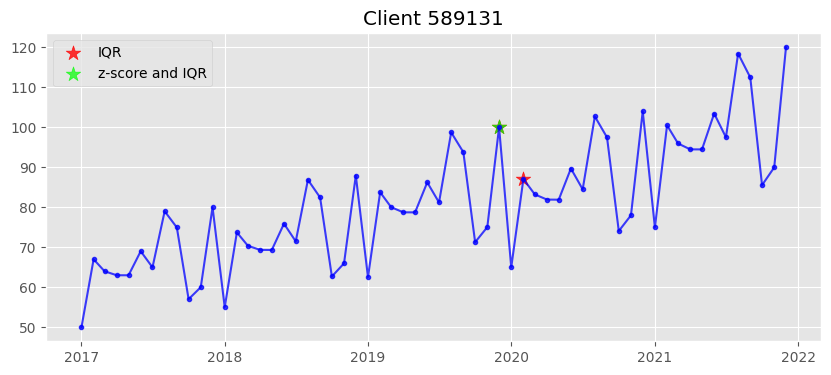

##################################################
################# Client 499072 ##################
##################################################
***********Anomalies found with z-score***********


date
2020-03-01    83.194457
Name: amount_mean, dtype: float64

*************Anomalies found with IQR*************


date
2020-03-01     83.194457
2020-04-01     81.917480
2020-06-01     89.676219
2020-07-01     84.493628
2021-08-01    118.481263
2021-09-01    112.508136
2021-11-01     90.014669
2021-12-01    120.077164
Name: amount_mean, dtype: float64

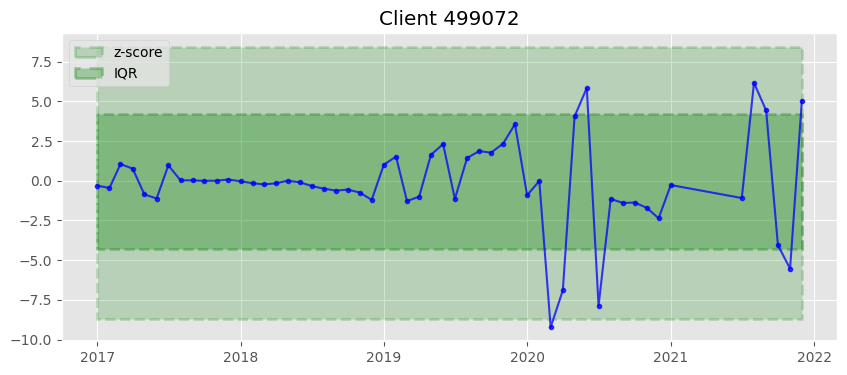

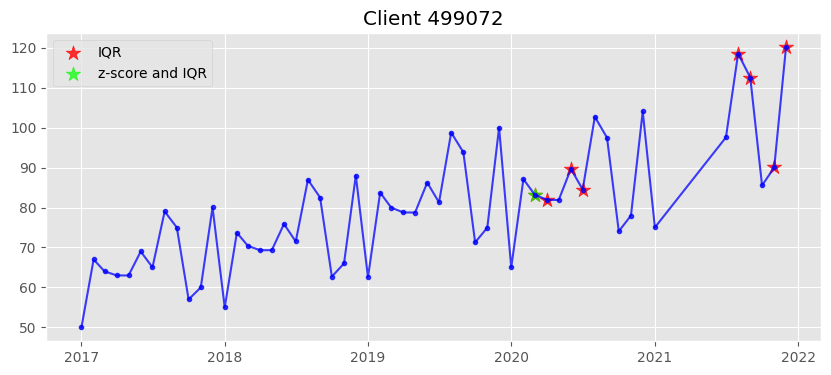

In [ ]:
for client in clients:
    current_client = df[df['client_id'] == client].set_index('date')['amount_mean']

    stl = STL(current_client, period = 12)
    result = stl.fit()
    resid = result.resid

    find_anomalies(current_client, resid, client)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


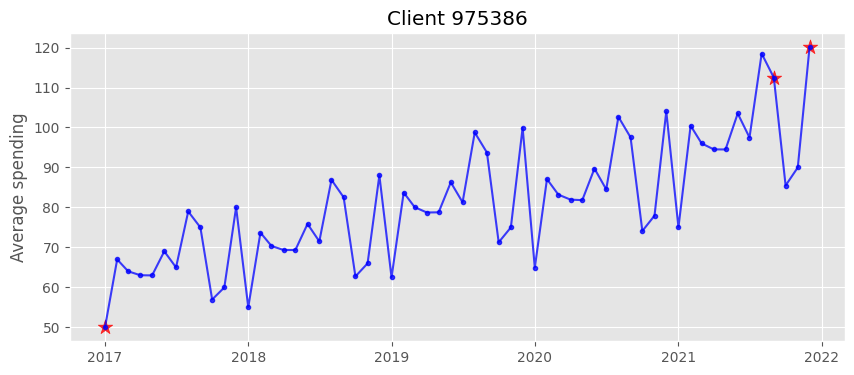

client_id       date  amount_mean  amount_count
714     975386 2017-01-01    50.006612             6
770     975386 2021-09-01   112.477220            24
773     975386 2021-12-01   120.073902             7

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


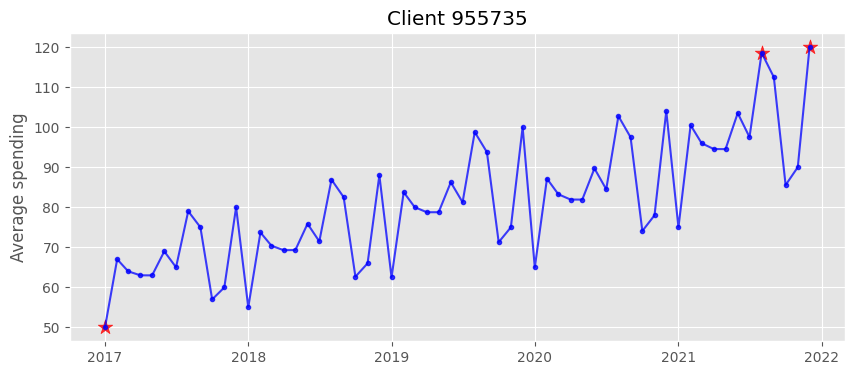

client_id       date  amount_mean  amount_count
594     955735 2017-01-01    50.038410             4
649     955735 2021-08-01   118.524005            30
653     955735 2021-12-01   119.918954             7

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


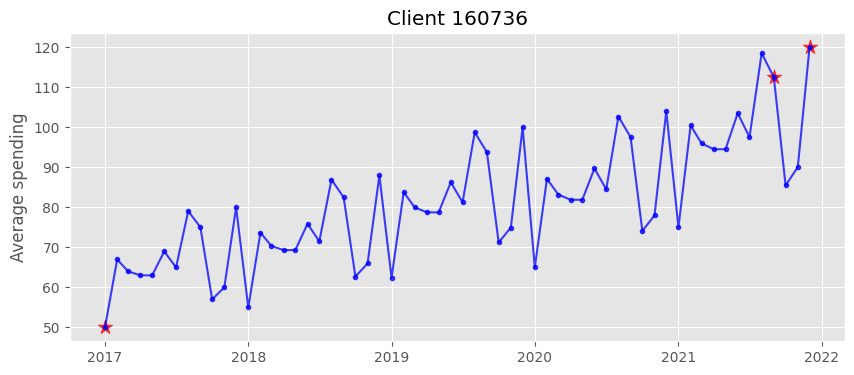

client_id       date  amount_mean  amount_count
60      160736 2017-01-01    50.047809             5
116     160736 2021-09-01   112.491057            28
119     160736 2021-12-01   119.973821             6

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


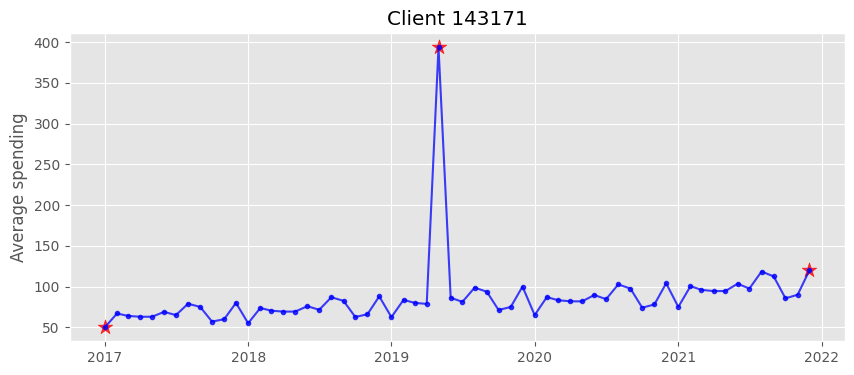

client_id       date  amount_mean  amount_count
0      143171 2017-01-01    50.059780             6
28     143171 2019-05-01   393.629502            30
59     143171 2021-12-01   119.954088             7

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


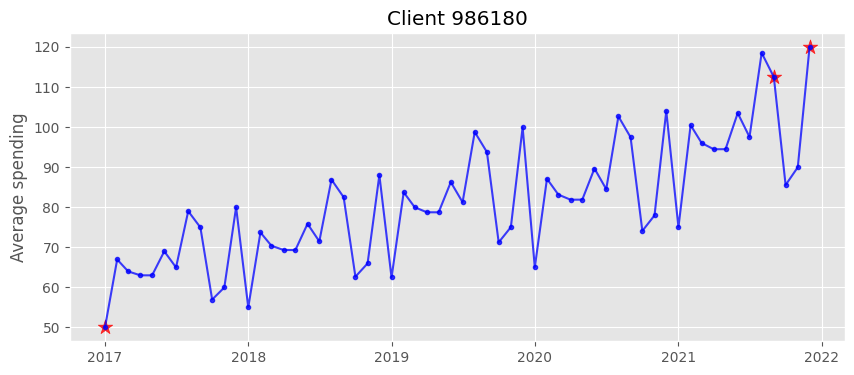

client_id       date  amount_mean  amount_count
774     986180 2017-01-01    50.054940             2
830     986180 2021-09-01   112.496239            27
833     986180 2021-12-01   119.916524             6

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


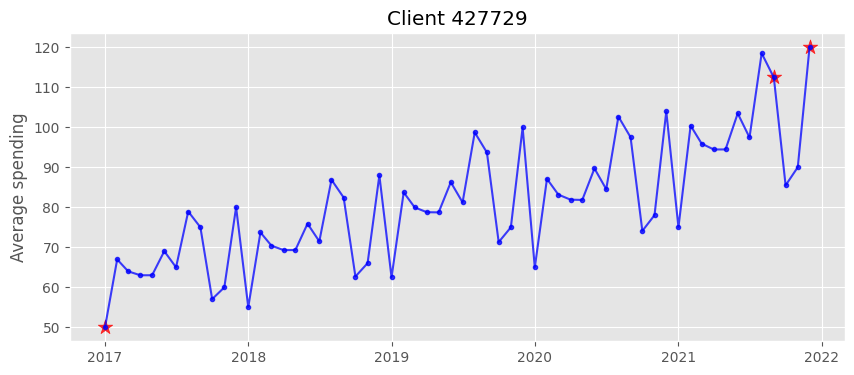

client_id       date  amount_mean  amount_count
239     427729 2017-01-01    49.994316             5
295     427729 2021-09-01   112.477953            26
298     427729 2021-12-01   120.037550             6

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


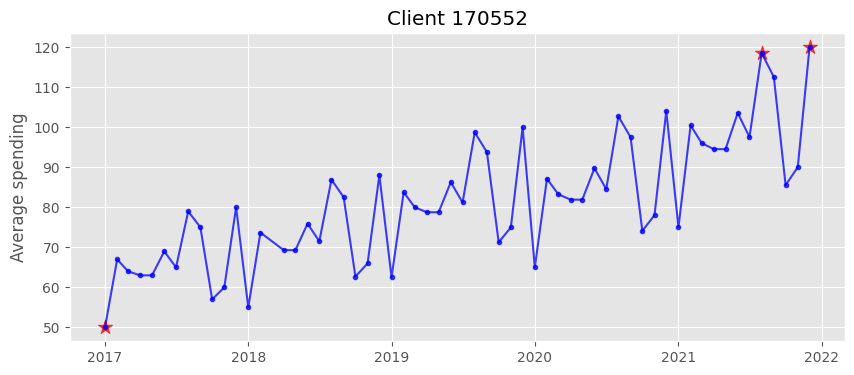

client_id       date  amount_mean  amount_count
180     170552 2017-01-01    50.041918             6
234     170552 2021-08-01   118.484839            26
238     170552 2021-12-01   119.931829             5

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


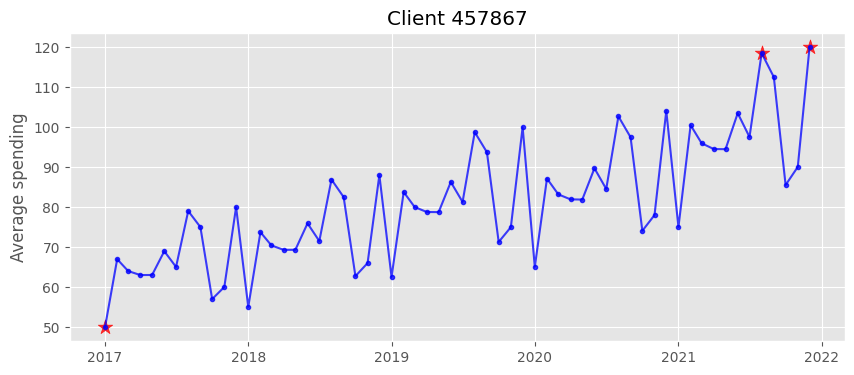

client_id       date  amount_mean  amount_count
299     457867 2017-01-01    49.933823             5
354     457867 2021-08-01   118.504498            26
358     457867 2021-12-01   119.972596             6

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


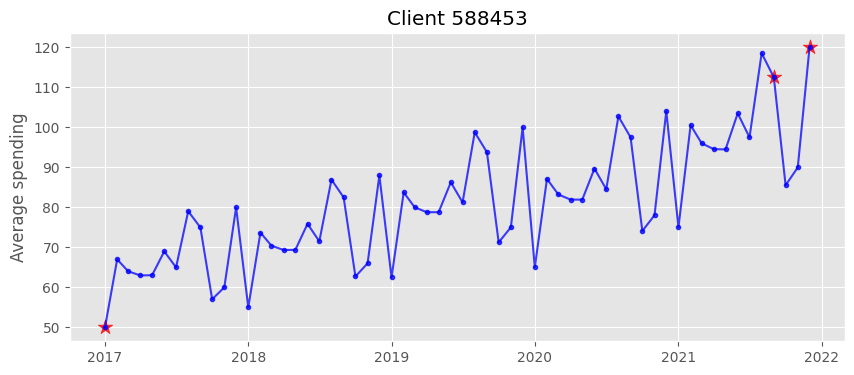

client_id       date  amount_mean  amount_count
414     588453 2017-01-01    50.023051             5
470     588453 2021-09-01   112.477401            30
473     588453 2021-12-01   119.987704             7

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


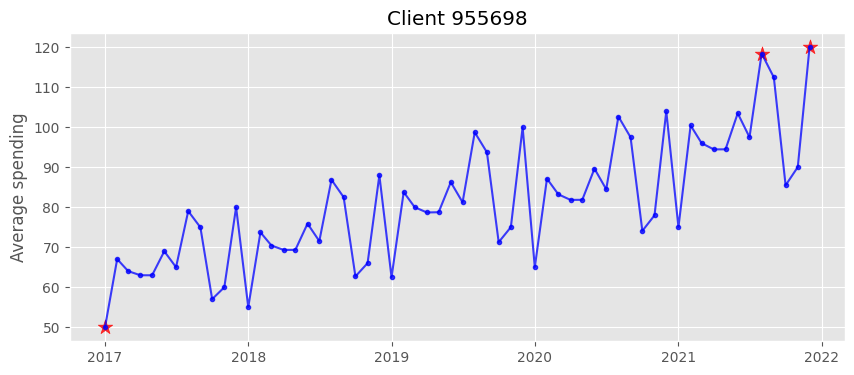

client_id       date  amount_mean  amount_count
534     955698 2017-01-01    49.949088             5
589     955698 2021-08-01   118.480031            28
593     955698 2021-12-01   120.041505             6

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


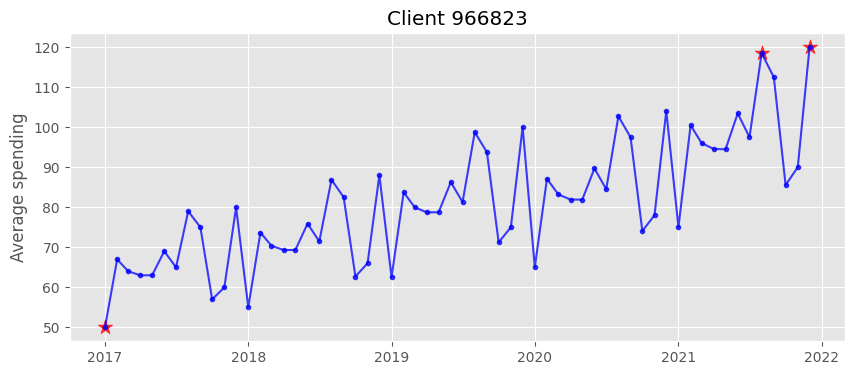

client_id       date  amount_mean  amount_count
654     966823 2017-01-01    50.019520             5
709     966823 2021-08-01   118.487197            27
713     966823 2021-12-01   119.955770             7

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


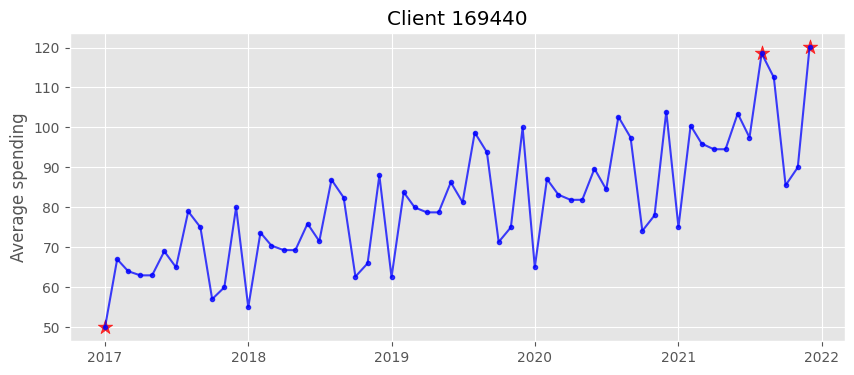

client_id       date  amount_mean  amount_count
120     169440 2017-01-01    49.986236             6
175     169440 2021-08-01   118.521937            30
179     169440 2021-12-01   120.064968             7

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


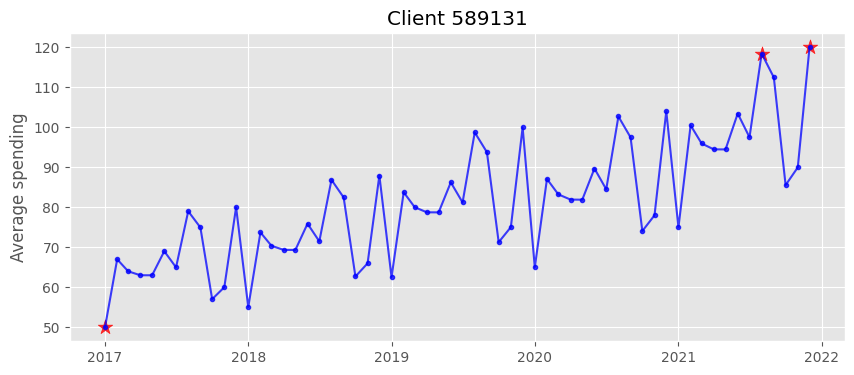

client_id       date  amount_mean  amount_count
474     589131 2017-01-01    49.986093             5
529     589131 2021-08-01   118.461477            29
533     589131 2021-12-01   120.039410             7

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


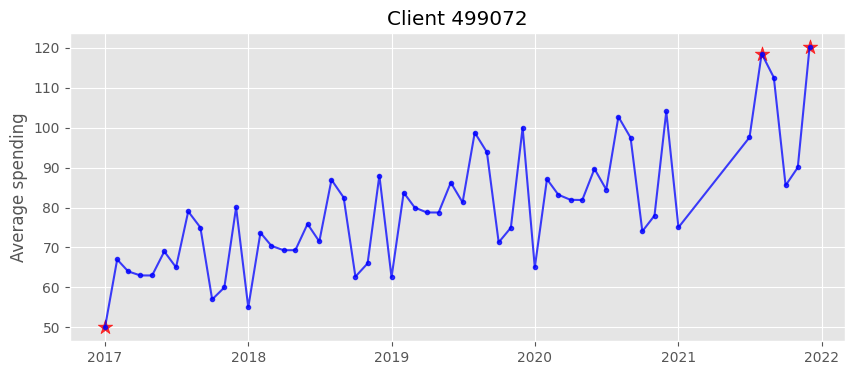

client_id       date  amount_mean  amount_count
359     499072 2017-01-01    50.039501             5
409     499072 2021-08-01   118.481263            30
413     499072 2021-12-01   120.077164             7

In [ ]:
for client in clients:

    # get single client data
    current_client = df[df['client_id'] == client]
    # define model
    model =  IsolationForest(contamination = 0.05)
    # train the model
    model.fit(current_client[['amount_mean']])

    # print(current_client)
    # predict outliers (output -1 is outlier, output 1 is not outlier)
    outliers = np.array(model.predict(current_client[['amount_mean']]))
    # convert output to create filter
    outliers[outliers == 1] = False
    outliers[outliers == -1] = True
    # create filter
    outliers = np.array(outliers, dtype = bool)


    # Plot data with identified residuals
    plt.figure(figsize=(10,4))
    plt.style.use('ggplot')
    plt.plot(current_client.date, current_client.amount_mean, marker='.',
             color = 'blue', alpha = 0.75)
    plt.scatter(current_client.loc[outliers].date, current_client.loc[outliers].amount_mean,
                s = 120, color='r', marker='*', alpha = 0.8, label = "IQR")
    plt.title(f"Client {client}")
    plt.ylabel('Average spending', fontsize=12)
    plt.show()

    # Print outliers in case the have been found
    if outliers.any():
        display(current_client[outliers])

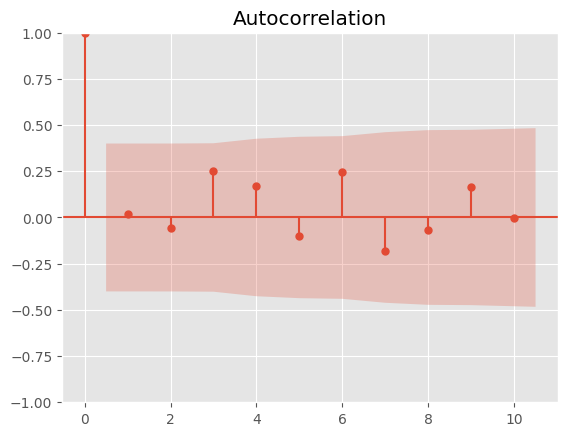

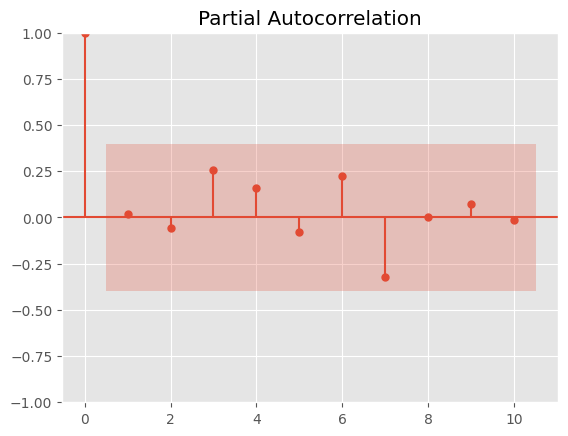

In [ ]:
#Get the data from specific client we want to analyze and separate in training and testing.
sp_client = df[df['client_id'] == 499072] # Full data
sp_client_train = df[(df['client_id'] == 499072) & (df['date'].dt.strftime("%Y").isin(['2017','2018']))] # training
sp_client_train_mean = sp_client_train['amount_mean']
sp_client_test = df[(df['client_id'] == 499072) & (df['date'].dt.strftime("%Y").isin([ '2019','2020', '2021']))] # testing

# plot autocorrelation and partial autocorrelation plots
plot_acf(sp_client_train_mean, lags = 10);
plot_pacf(sp_client_train_mean, lags = 10);

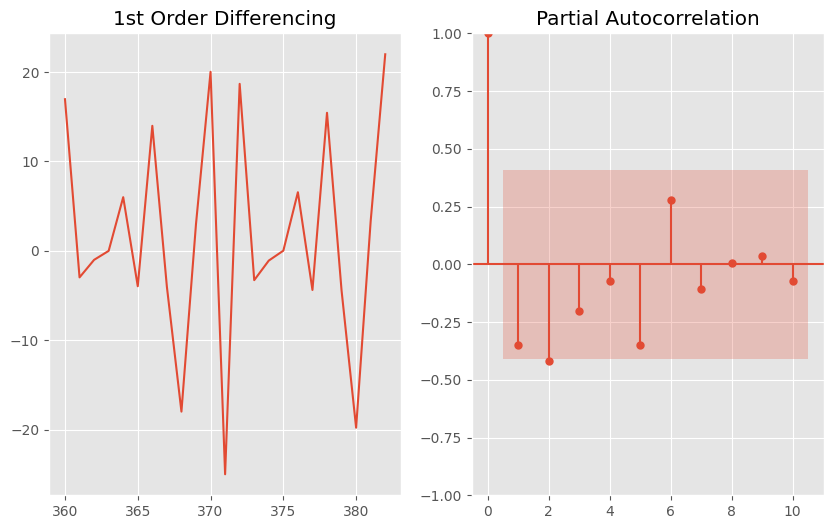

In [ ]:
f = plt.figure(figsize=(10,6))
ax1 = f.add_subplot(121)
ax1.set_title('1st Order Differencing')
ax1.plot(sp_client_train_mean.diff())

ax2 = f.add_subplot(122)
plot_pacf(sp_client_train_mean.diff().dropna(), lags = 10, ax = ax2)
plt.show()

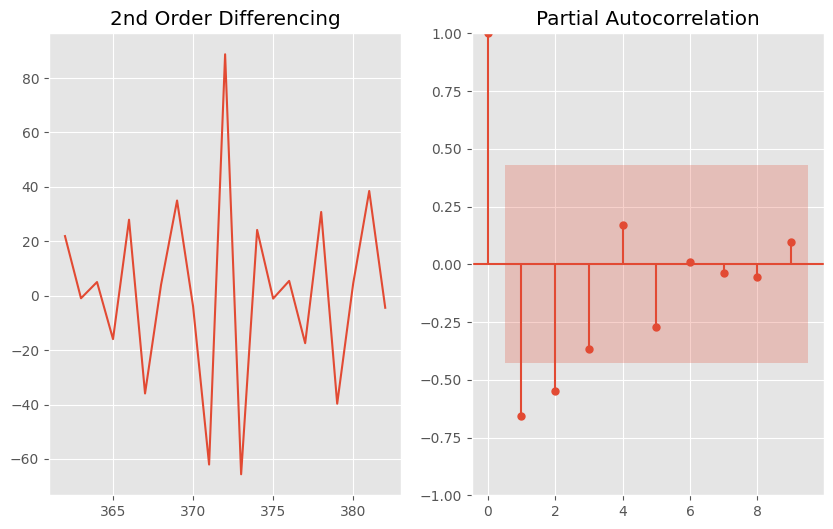

In [ ]:
f = plt.figure(figsize=(10,6))
ax1 = f.add_subplot(121)
ax1.set_title('2nd Order Differencing')
ax1.plot(sp_client_train_mean.diff().diff().diff())

ax2 = f.add_subplot(122)
plot_pacf(sp_client_train_mean.diff().diff().diff().dropna(), lags = 9, ax = ax2)
plt.show()

In [ ]:
result = adfuller(sp_client_train_mean.dropna())
print('p-value: ', result[1])

result = adfuller(sp_client_train_mean.diff().dropna())
print('p-value: ', result[1])

result = adfuller(sp_client_train_mean.diff().diff().dropna())
print('p-value: ', result[1])

p-value:  0.00022129076135470803
p-value:  4.3164806177305856e-05
p-value:  5.681406360441141e-05


In [ ]:
arima_model = SARIMAX(sp_client_train_mean, order=(2,0,1), seasonal_order = (1,0,3,12))
model = arima_model.fit()
print(model.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations 

                                         SARIMAX Results                                          
Dep. Variable:                                amount_mean   No. Observations:                   24
Model:             SARIMAX(2, 0, 1)x(1, 0, [1, 2, 3], 12)   Log Likelihood                 -65.061
Date:                                    Mon, 08 Jul 2024   AIC                            146.121
Time:                                            09:32:22   BIC                            155.546
Sample:                                                 0   HQIC                           148.622
                                                     - 24                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7716      0.388      1.986      0

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_ind

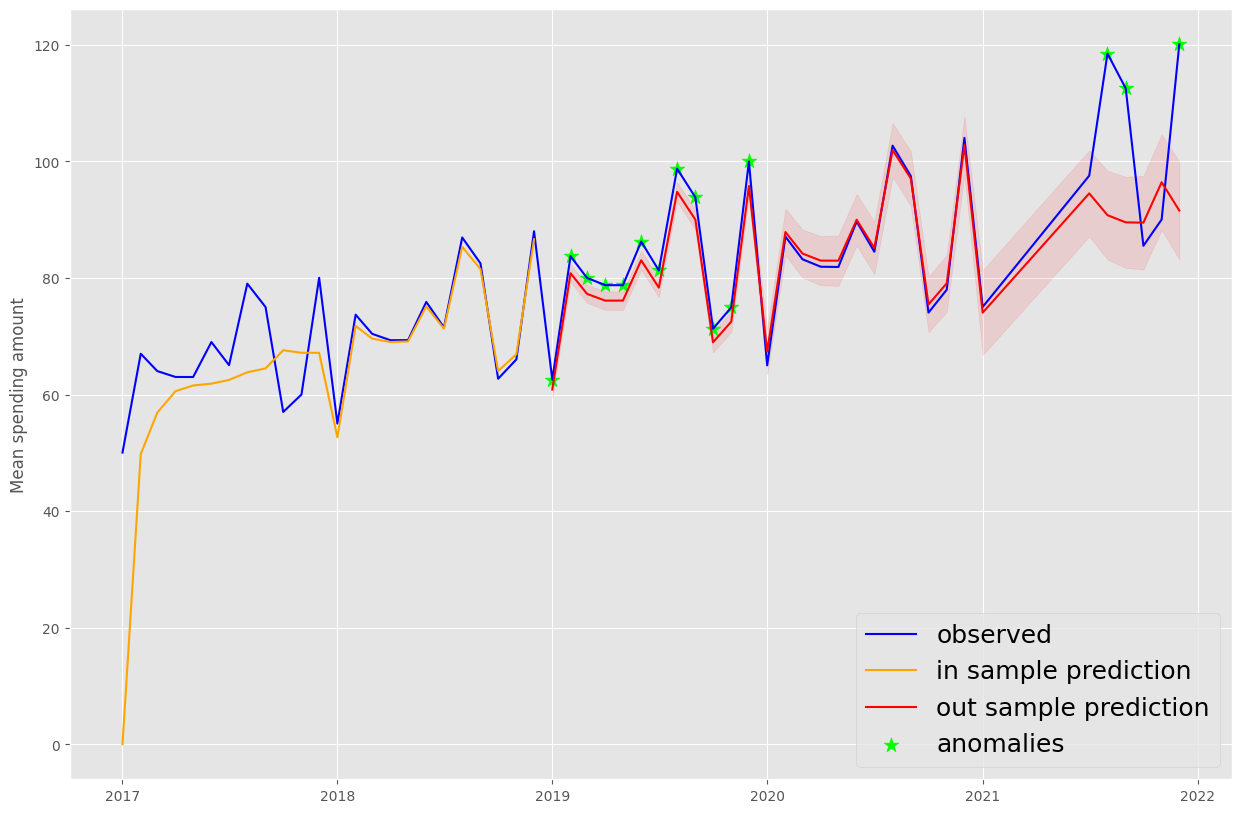

In [ ]:
# define start and end points for intervals used in prediction
start_out = len(sp_client_train)
end_out = len(sp_client_train) + len(sp_client_test) - 1
start_in = 0
end_in = len(sp_client_train) - 1

# Predict in sample and outsample
in_sample_prediction = model.predict(start=start_in, end=end_in, dynamic = False, typ='levels')
out_sample_prediction = model.predict(start=start_out, end=end_out, dynamic = False, typ='levels') # same as forecast(len(test_set))

# Get confidence interval
lower_ci = model.get_forecast(len(sp_client_test)).summary_frame().mean_ci_lower
upper_ci = model.get_forecast(len(sp_client_test)).summary_frame().mean_ci_upper

# Define filter to find outliers
filter = [True if ((sp_client_test['amount_mean'].iloc[i] > upper_ci.iloc[i]) |
          (sp_client_test['amount_mean'].iloc[i] < lower_ci.iloc[i])) else False
          for i in range(len(sp_client_test))]


# plot observed data, in and out sample predictions and confidence intervals
plt.figure(figsize=(15,10))
plt.plot(sp_client['date'], sp_client['amount_mean'], color = 'blue', label='observed')
plt.plot(sp_client_train['date'], in_sample_prediction, color = 'orange', label = 'in sample prediction')
plt.plot(sp_client_test['date'], out_sample_prediction, color = 'red', label = 'out sample prediction')
plt.fill_between(sp_client_test['date'], lower_ci, upper_ci, color='red', alpha=0.1)
plt.scatter(sp_client_test.loc[filter]['date'], sp_client_test.loc[filter]['amount_mean'], s = 120, color='lime', marker='*', label = "anomalies")
plt.ylabel("Mean spending amount")
plt.legend(prop={'size': 18}, loc = "lower right")
plt.show()

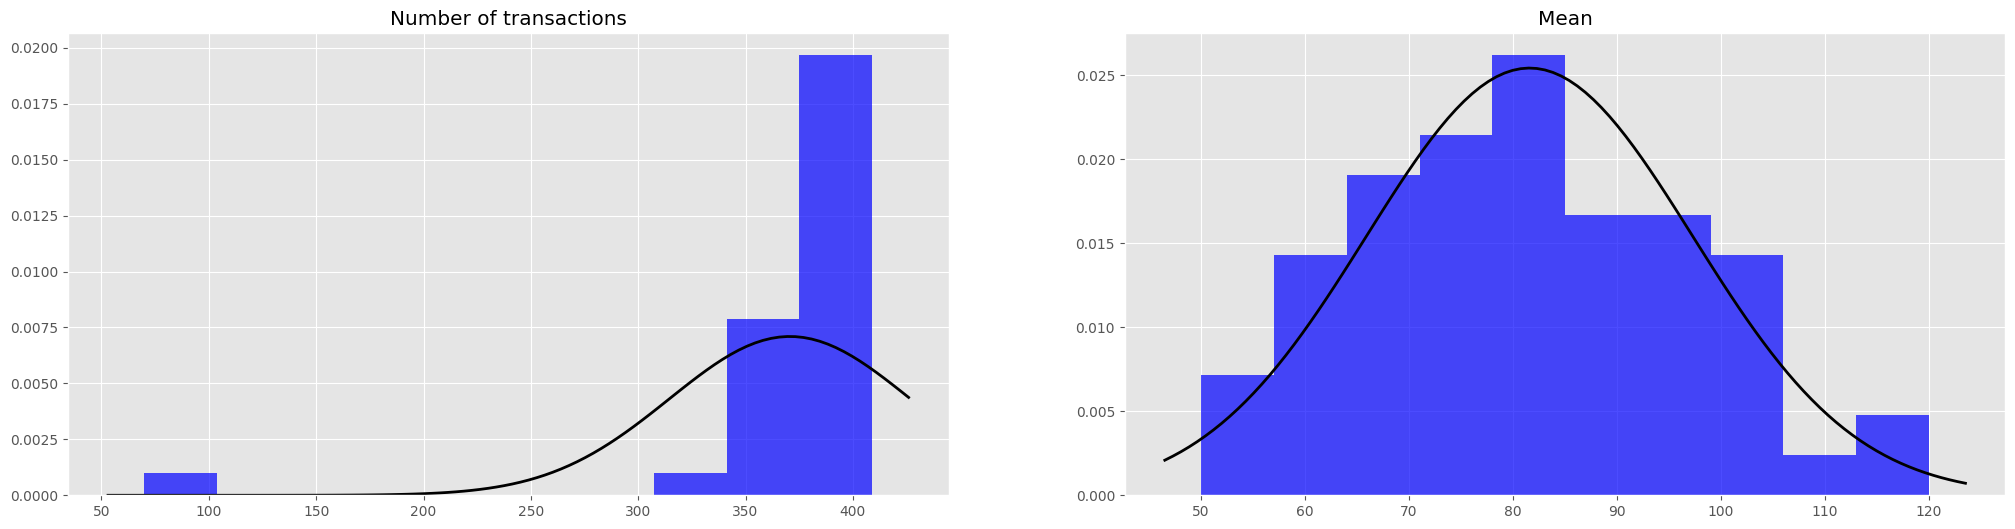

In [ ]:
def get_pdf(dataframe, column, xmin, xmax):
    """
    Calculates and returns normal distribution of a given pandas series.

    Inputs:
    :dataframe: dataframe.
    :column: column of the data frame from which we want to calculate gaussian distribution.
    :xmin: integer. Minimum value of the x axis for the future plot.
    :xmax: integer. Maximum value of the x axis for the future plot.

    Outputs:
    :x: array of values for the x axis of future plot
    :p: normal distribution of the input data.

    """


    mu, std = norm.fit(dataframe[column])
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)

    return x, p



f = plt.figure(figsize=(25,6))

ax1 = f.add_subplot(121)
# Plot the histogram.
ax1.hist(df_all['amount_count'], density=True, alpha=0.7, color='b')
# Plot the PDF.
xmin, xmax = plt.xlim()
x, p = get_pdf(df_all, 'amount_count', xmin, xmax)
ax1.plot(x, p, 'k', linewidth=2)
ax1.set_title('Number of transactions')


ax2 = f.add_subplot(122)
# Plot the histogram.
ax2.hist(df_all['amount_mean'], density=True, alpha=0.7, color='b')
# Plot the PDF.
xmin, xmax = plt.xlim()
x, p = get_pdf(df_all, 'amount_mean', xmin, xmax)
ax2.plot(x, p, 'k', linewidth=2)
ax2.set_title('Mean')


plt.show()

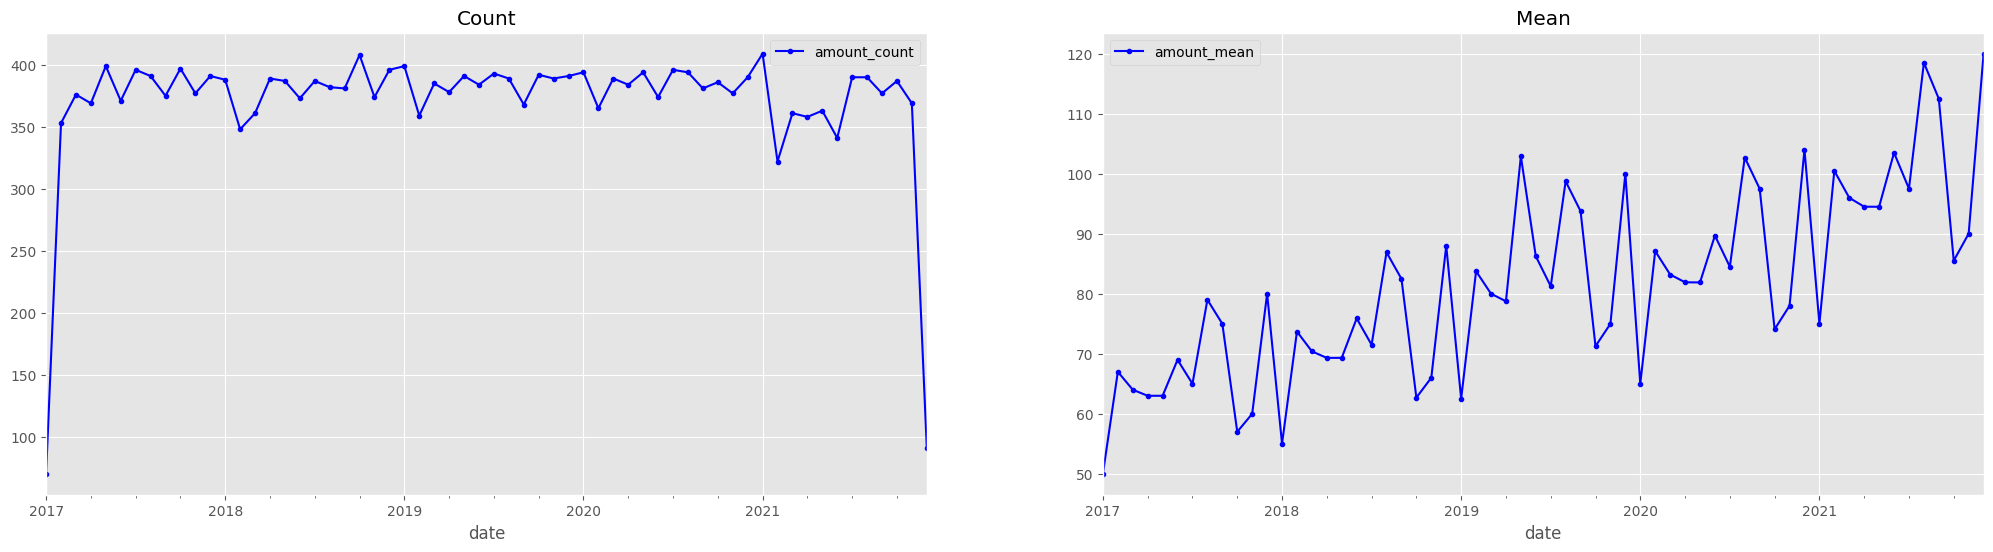

In [ ]:
f = plt.figure(figsize=(25,6))

ax1 = f.add_subplot(121)
df_all.plot(x= 'date', y= 'amount_count', ax = ax1, color = 'blue', marker='.')
ax1.set_title('Count')

ax2 = f.add_subplot(122)
df_all.plot(x= 'date', y= 'amount_mean', ax = ax2, color = 'blue', marker='.')
ax2.set_title('Mean')

plt.show()

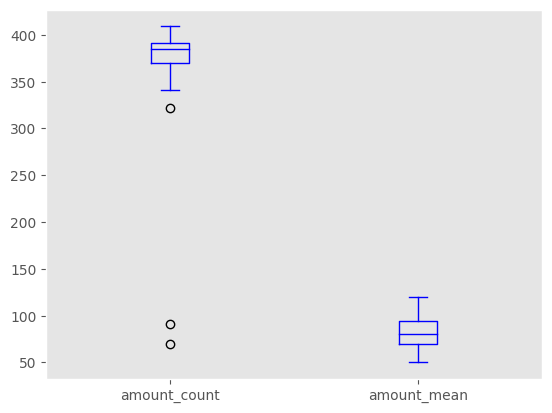

In [ ]:
boxplot = df_all.boxplot(column=['amount_count', 'amount_mean'], color = 'blue', grid=False)

##################################################
################### Client All ###################
##################################################
***********Anomalies found with z-score***********


date
2019-05-01    102.907602
Name: amount_mean, dtype: float64

*************Anomalies found with IQR*************


date
2018-05-01     69.319691
2019-05-01    102.907602
2019-12-01     99.991512
2020-05-01     81.884656
Name: amount_mean, dtype: float64

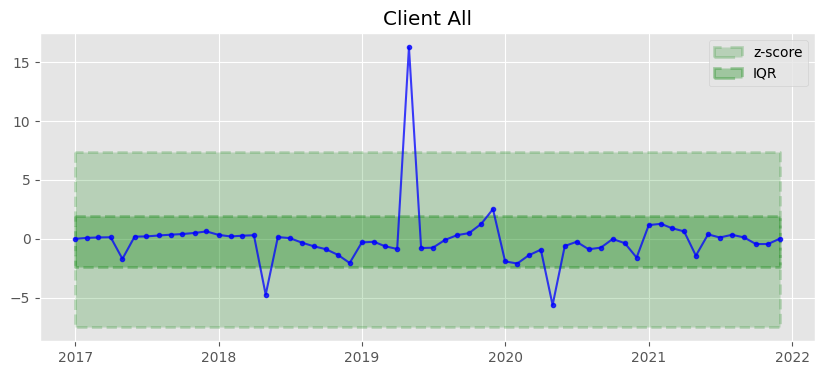

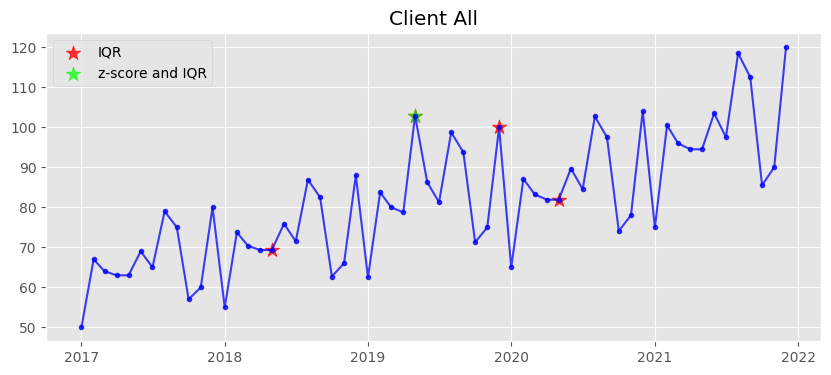

In [ ]:
all_df = df_all.set_index('date')['amount_mean']

stl = STL(all_df, period = 12)
result = stl.fit()
resid = result.resid

find_anomalies(all_df, resid, "All")